# Predict #
To be re-inserted into main Jupyter Notebook after.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# For neural networks.
import keras as kr
# For data frames.
import pandas as pd
# For numerical arrays.
import numpy as np
# For preprocessing data.
import sklearn.preprocessing as pre
# For splitting data sets.
import sklearn.model_selection as mod
# For whitening.
import sklearn.decomposition as dec
# to write to csv file
import csv

Using TensorFlow backend.


In [2]:
# Import sklearn for comparison too
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

In [3]:
# Load the dataset into a dataframe
data = pd.DataFrame(data = load_boston().data, columns= load_boston().feature_names)
# Add the house price
data["MEDV"] = load_boston().target
# Quick check that all is ok
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


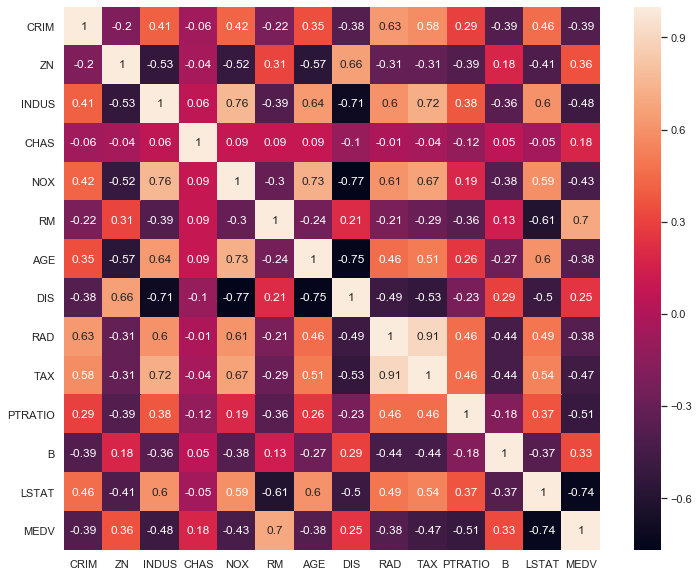

In [4]:
sns.set(rc={'figure.figsize':(12,10)})
correlation_matrix = data.corr().round(2)
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True)

In [5]:
correlation_matrix["MEDV"]

CRIM      -0.39
ZN         0.36
INDUS     -0.48
CHAS       0.18
NOX       -0.43
RM         0.70
AGE       -0.38
DIS        0.25
RAD       -0.38
TAX       -0.47
PTRATIO   -0.51
B          0.33
LSTAT     -0.74
MEDV       1.00
Name: MEDV, dtype: float64

In [6]:
cm = correlation_matrix.transform(func= lambda x: abs(x))["MEDV"].sort_values(ascending=False)
cm = cm.drop("MEDV",axis=0)
cm

LSTAT      0.74
RM         0.70
PTRATIO    0.51
INDUS      0.48
TAX        0.47
NOX        0.43
CRIM       0.39
RAD        0.38
AGE        0.38
ZN         0.36
B          0.33
DIS        0.25
CHAS       0.18
Name: MEDV, dtype: float64

Because the TAX and RAD parameters are highly correlated (0.91) both should not be  used in training any model. As TAX has a higher correlation than RAD, the RAD feature will be dropped.

In [7]:
cm = cm.drop("RAD",axis=0)
cm

LSTAT      0.74
RM         0.70
PTRATIO    0.51
INDUS      0.48
TAX        0.47
NOX        0.43
CRIM       0.39
AGE        0.38
ZN         0.36
B          0.33
DIS        0.25
CHAS       0.18
Name: MEDV, dtype: float64

In [8]:
# Putting all possible parameters in a list in order of correlation
params = []
for i in range(0, len(cm)):
    params.append(cm.index[i])

In [9]:
y = data['MEDV'] # outputs

def getInputs(noPar):
    # Split the dataset into what we are using
    return data[params[:noPar]] # inputs

In [10]:
def scaleDS(inputs):
    # Adding a scaler
    scaler = pre.StandardScaler()
    scaler.fit(inputs)
    return scaler.transform(inputs)

In [11]:
def splitDS(inputs):
    global x_train, x_test, y_train, y_test
    # Split the dataset into training and testing
    x_train, x_test, y_train, y_test = mod.train_test_split(inputs, y, test_size=testSize)

In [12]:
def createModel(actType, optType):
    global noParams, noEpoch, batchSize
    # Create our model
    m = kr.models.Sequential()
    m.add(kr.layers.Dense(20, input_dim=noParams, activation = actType))
    m.add(kr.layers.Dense(1, activation="linear"))
    m.compile(loss = "mean_squared_error", optimizer =optType)
    # Train the network
    m.fit(x_train, y_train, epochs=noEpoch, batch_size=batchSize)
    return m

In [13]:
def doModel(model, epo, bs):
    global x_trian, x_test, y_tran, y_test, batchSize
    # Train the network
    model.fit(x_train, y_train, epochs=epo, batch_size=bs)
    # Calculate the loss function (Mean squared error in our case)
    return model.evaluate(x_test, y_test)

In [14]:
# Headings for the data
results= []

In [76]:
# Parameterise everything

# Do you want to create and test all the models? 
# If yes, set the following to true, if no, leave at false and data from previous run will be read into dataframe
yesCreateModels = True

# No of variables to include in predictions
noParams = 4 

# Test / Train Split
testSize = 0.3

# All the activations
acts = ["relu", "tanh", "sigmoid", "exponential", "elu", "linear"]
#act = acts[5]

# Optimisers
opts= ["sgd", "adam", "nadam"]
opt = opts[0]

# model trial settings
noEpoch= 100
batchSize = 10

# Whether the data should be scaled or not
scaling = True

if yesCreateModels == True:
    # Check for increasing no of attributes and all activations
    for act in acts:
        for noParams in range(1,12):
            # Create your inputs
            x = getInputs(noParams)
            # Scale if it is called for
            if scaling  == False:
                x_scaled = scaleDS(x)
            else:
                x_scaled = x
            # Split into training and testing data
            splitDS(x_scaled)
            # Create the model based on the paramters supplied
            m = createModel(act, opt)
            # Append the settings and final loss results after fitting and evaluating the model to the results file
            results.append([noParams, scaling, testSize, act, opt, noEpoch, batchSize, doModel(m, noEpoch, batchSize)])

Epoch 1/100
354/354 [==============================] - 1s 2ms/step - loss: 578.4548
Epoch 2/100
354/354 [==============================] - 0s 175us/step - loss: 551.1777
Epoch 3/100
354/354 [==============================] - 0s 175us/step - loss: 516.0545
Epoch 4/100
354/354 [==============================] - 0s 167us/step - loss: 471.6447
Epoch 5/100
354/354 [==============================] - 0s 152us/step - loss: 418.3288
Epoch 6/100
354/354 [==============================] - 0s 227us/step - loss: 357.6833
Epoch 7/100
354/354 [==============================] - 0s 203us/step - loss: 292.0580
Epoch 8/100
354/354 [==============================] - 0s 211us/step - loss: 228.0937
Epoch 9/100
354/354 [==============================] - 0s 209us/step - loss: 170.9487
Epoch 10/100
354/354 [==============================] - 0s 215us/step - loss: 124.3063
Epoch 11/100
354/354 [==============================] - 0s 221us/step - loss: 89.1829
Epoch 12/100
354/354 [==============================] -

354/354 [==============================] - 0s 212us/step - loss: 33.5010
Epoch 97/100
354/354 [==============================] - 0s 233us/step - loss: 33.4361
Epoch 98/100
354/354 [==============================] - 0s 209us/step - loss: 33.4235
Epoch 99/100
354/354 [==============================] - 0s 214us/step - loss: 33.4704
Epoch 100/100
354/354 [==============================] - 0s 198us/step - loss: 33.7543
Epoch 1/100
354/354 [==============================] - 0s 199us/step - loss: 33.3825
Epoch 2/100
354/354 [==============================] - 0s 219us/step - loss: 33.3722
Epoch 3/100
354/354 [==============================] - 0s 204us/step - loss: 33.3853
Epoch 4/100
354/354 [==============================] - 0s 208us/step - loss: 33.3733
Epoch 5/100
354/354 [==============================] - 0s 202us/step - loss: 33.2825
Epoch 6/100
354/354 [==============================] - 0s 198us/step - loss: 33.2790
Epoch 7/100
354/354 [==============================] - 0s 214us/step - l

354/354 [==============================] - 0s 216us/step - loss: 32.1340
Epoch 92/100
354/354 [==============================] - 0s 224us/step - loss: 32.1249
Epoch 93/100
354/354 [==============================] - 0s 205us/step - loss: 32.1211
Epoch 94/100
354/354 [==============================] - 0s 216us/step - loss: 32.1107
Epoch 95/100
354/354 [==============================] - 0s 219us/step - loss: 32.0753
Epoch 96/100
354/354 [==============================] - 0s 215us/step - loss: 32.0437
Epoch 97/100
354/354 [==============================] - 0s 220us/step - loss: 32.1475
Epoch 98/100
354/354 [==============================] - 0s 223us/step - loss: 32.0105
Epoch 99/100
354/354 [==============================] - 0s 201us/step - loss: 32.0375
Epoch 100/100
152/152 [==============================] - 0s 455us/step
Epoch 1/100
354/354 [==============================] - 1s 2ms/step - loss: 579.6314
Epoch 2/100
354/354 [==============================] - 0s 179us/step - loss: 555.568

354/354 [==============================] - 0s 207us/step - loss: 19.4636
Epoch 86/100
354/354 [==============================] - 0s 205us/step - loss: 19.4676
Epoch 87/100
354/354 [==============================] - 0s 207us/step - loss: 19.4465
Epoch 88/100
354/354 [==============================] - 0s 213us/step - loss: 19.3756
Epoch 89/100
354/354 [==============================] - 0s 207us/step - loss: 19.3680
Epoch 90/100
354/354 [==============================] - 0s 202us/step - loss: 19.3233
Epoch 91/100
354/354 [==============================] - 0s 201us/step - loss: 19.2995
Epoch 92/100
354/354 [==============================] - 0s 195us/step - loss: 19.2722
Epoch 93/100
354/354 [==============================] - 0s 206us/step - loss: 19.2163
Epoch 94/100
354/354 [==============================] - 0s 202us/step - loss: 19.1749
Epoch 95/100
354/354 [==============================] - 0s 196us/step - loss: 19.1308
Epoch 96/100
354/354 [==============================] - 0s 205us/st

354/354 [==============================] - 0s 213us/step - loss: 17.5092
Epoch 81/100
354/354 [==============================] - 0s 208us/step - loss: 17.5518
Epoch 82/100
354/354 [==============================] - 0s 170us/step - loss: 17.4977
Epoch 83/100
354/354 [==============================] - 0s 185us/step - loss: 17.4603
Epoch 84/100
354/354 [==============================] - 0s 197us/step - loss: 17.4895
Epoch 85/100
354/354 [==============================] - 0s 204us/step - loss: 17.4778
Epoch 86/100
354/354 [==============================] - 0s 213us/step - loss: 17.4229
Epoch 87/100
354/354 [==============================] - 0s 213us/step - loss: 17.4911
Epoch 88/100
354/354 [==============================] - 0s 207us/step - loss: 17.4663
Epoch 89/100
354/354 [==============================] - 0s 203us/step - loss: 17.3988
Epoch 90/100
354/354 [==============================] - 0s 214us/step - loss: 17.3608
Epoch 91/100
354/354 [==============================] - 0s 213us/st

354/354 [==============================] - 0s 201us/step - loss: 14.2709
Epoch 75/100
354/354 [==============================] - 0s 200us/step - loss: 14.1800
Epoch 76/100
354/354 [==============================] - 0s 201us/step - loss: 14.1364
Epoch 77/100
354/354 [==============================] - 0s 206us/step - loss: 14.1197
Epoch 78/100
354/354 [==============================] - 0s 198us/step - loss: 14.0861
Epoch 79/100
354/354 [==============================] - 0s 198us/step - loss: 14.0180
Epoch 80/100
354/354 [==============================] - 0s 204us/step - loss: 14.0238
Epoch 81/100
354/354 [==============================] - 0s 201us/step - loss: 13.9398
Epoch 82/100
354/354 [==============================] - 0s 203us/step - loss: 13.9427
Epoch 83/100
354/354 [==============================] - 0s 200us/step - loss: 13.8931
Epoch 84/100
354/354 [==============================] - 0s 192us/step - loss: 13.8121
Epoch 85/100
354/354 [==============================] - 0s 204us/st

354/354 [==============================] - 0s 210us/step - loss: 12.4040
Epoch 70/100
354/354 [==============================] - 0s 209us/step - loss: 12.3597
Epoch 71/100
354/354 [==============================] - 0s 202us/step - loss: 12.3975
Epoch 72/100
354/354 [==============================] - 0s 216us/step - loss: 12.4751
Epoch 73/100
354/354 [==============================] - 0s 203us/step - loss: 12.3942
Epoch 74/100
354/354 [==============================] - 0s 210us/step - loss: 12.3707
Epoch 75/100
354/354 [==============================] - 0s 198us/step - loss: 12.3449
Epoch 76/100
354/354 [==============================] - 0s 204us/step - loss: 12.3387
Epoch 77/100
354/354 [==============================] - 0s 206us/step - loss: 12.3524
Epoch 78/100
354/354 [==============================] - 0s 196us/step - loss: 12.4172
Epoch 79/100
354/354 [==============================] - 0s 196us/step - loss: 12.3681
Epoch 80/100
354/354 [==============================] - 0s 204us/st

354/354 [==============================] - 0s 205us/step - loss: 16.7017
Epoch 64/100
354/354 [==============================] - 0s 202us/step - loss: 16.6369
Epoch 65/100
354/354 [==============================] - 0s 199us/step - loss: 16.5466
Epoch 66/100
354/354 [==============================] - 0s 202us/step - loss: 16.4667
Epoch 67/100
354/354 [==============================] - 0s 199us/step - loss: 16.4438
Epoch 68/100
354/354 [==============================] - 0s 203us/step - loss: 16.3216
Epoch 69/100
354/354 [==============================] - 0s 200us/step - loss: 16.2495
Epoch 70/100
354/354 [==============================] - 0s 206us/step - loss: 16.1821
Epoch 71/100
354/354 [==============================] - 0s 207us/step - loss: 16.1345
Epoch 72/100
354/354 [==============================] - 0s 194us/step - loss: 16.0419
Epoch 73/100
354/354 [==============================] - 0s 207us/step - loss: 15.9475
Epoch 74/100
354/354 [==============================] - 0s 200us/st

354/354 [==============================] - 0s 198us/step - loss: 12.8462
Epoch 59/100
354/354 [==============================] - 0s 198us/step - loss: 12.8427
Epoch 60/100
354/354 [==============================] - 0s 211us/step - loss: 12.8750
Epoch 61/100
354/354 [==============================] - 0s 208us/step - loss: 12.7827
Epoch 62/100
354/354 [==============================] - 0s 196us/step - loss: 12.7918
Epoch 63/100
354/354 [==============================] - 0s 203us/step - loss: 12.7402
Epoch 64/100
354/354 [==============================] - 0s 188us/step - loss: 12.7620
Epoch 65/100
354/354 [==============================] - 0s 193us/step - loss: 12.7798
Epoch 66/100
354/354 [==============================] - 0s 225us/step - loss: 12.6942
Epoch 67/100
354/354 [==============================] - 0s 209us/step - loss: 12.7083
Epoch 68/100
354/354 [==============================] - 0s 211us/step - loss: 12.6905
Epoch 69/100
354/354 [==============================] - 0s 227us/st

354/354 [==============================] - 0s 213us/step - loss: 16.8119
Epoch 53/100
354/354 [==============================] - 0s 211us/step - loss: 16.7435
Epoch 54/100
354/354 [==============================] - 0s 202us/step - loss: 16.5291
Epoch 55/100
354/354 [==============================] - 0s 209us/step - loss: 16.3917
Epoch 56/100
354/354 [==============================] - 0s 204us/step - loss: 16.2949
Epoch 57/100
354/354 [==============================] - 0s 204us/step - loss: 16.1784
Epoch 58/100
354/354 [==============================] - 0s 208us/step - loss: 16.0568
Epoch 59/100
354/354 [==============================] - 0s 209us/step - loss: 15.9386
Epoch 60/100
354/354 [==============================] - 0s 199us/step - loss: 15.8482
Epoch 61/100
354/354 [==============================] - 0s 209us/step - loss: 15.7841
Epoch 62/100
354/354 [==============================] - 0s 200us/step - loss: 15.7265
Epoch 63/100
354/354 [==============================] - 0s 204us/st

354/354 [==============================] - 0s 213us/step - loss: 12.5396
Epoch 48/100
354/354 [==============================] - 0s 208us/step - loss: 12.4792
Epoch 49/100
354/354 [==============================] - 0s 207us/step - loss: 12.4905
Epoch 50/100
354/354 [==============================] - 0s 214us/step - loss: 12.4812
Epoch 51/100
354/354 [==============================] - 0s 207us/step - loss: 12.4613
Epoch 52/100
354/354 [==============================] - 0s 216us/step - loss: 12.4581
Epoch 53/100
354/354 [==============================] - 0s 206us/step - loss: 12.4484
Epoch 54/100
354/354 [==============================] - 0s 195us/step - loss: 12.4397
Epoch 55/100
354/354 [==============================] - 0s 221us/step - loss: 12.4185
Epoch 56/100
354/354 [==============================] - 0s 199us/step - loss: 12.3560
Epoch 57/100
354/354 [==============================] - 0s 202us/step - loss: 12.3474
Epoch 58/100
354/354 [==============================] - 0s 199us/st

354/354 [==============================] - 0s 196us/step - loss: 16.4973
Epoch 42/100
354/354 [==============================] - 0s 202us/step - loss: 16.2837
Epoch 43/100
354/354 [==============================] - 0s 202us/step - loss: 16.0842
Epoch 44/100
354/354 [==============================] - 0s 208us/step - loss: 15.8582
Epoch 45/100
354/354 [==============================] - 0s 205us/step - loss: 15.7393
Epoch 46/100
354/354 [==============================] - 0s 210us/step - loss: 15.5430
Epoch 47/100
354/354 [==============================] - 0s 200us/step - loss: 15.3980
Epoch 48/100
354/354 [==============================] - 0s 204us/step - loss: 15.2608
Epoch 49/100
354/354 [==============================] - 0s 194us/step - loss: 15.0790
Epoch 50/100
354/354 [==============================] - 0s 196us/step - loss: 14.9538
Epoch 51/100
354/354 [==============================] - 0s 198us/step - loss: 14.8066
Epoch 52/100
354/354 [==============================] - 0s 199us/st

354/354 [==============================] - 0s 201us/step - loss: 10.6972
Epoch 37/100
354/354 [==============================] - 0s 205us/step - loss: 10.6894
Epoch 38/100
354/354 [==============================] - 0s 204us/step - loss: 10.6569
Epoch 39/100
354/354 [==============================] - 0s 200us/step - loss: 10.5952
Epoch 40/100
354/354 [==============================] - 0s 206us/step - loss: 10.5776
Epoch 41/100
354/354 [==============================] - 0s 210us/step - loss: 10.6122
Epoch 42/100
354/354 [==============================] - 0s 199us/step - loss: 10.4760
Epoch 43/100
354/354 [==============================] - 0s 202us/step - loss: 10.6287
Epoch 44/100
354/354 [==============================] - 0s 202us/step - loss: 10.5421
Epoch 45/100
354/354 [==============================] - 0s 204us/step - loss: 10.5342
Epoch 46/100
354/354 [==============================] - 0s 195us/step - loss: 10.4444
Epoch 47/100
354/354 [==============================] - 0s 193us/st

354/354 [==============================] - 0s 206us/step - loss: 17.5654
Epoch 32/100
354/354 [==============================] - 0s 201us/step - loss: 17.1502
Epoch 33/100
354/354 [==============================] - 0s 208us/step - loss: 16.8879
Epoch 34/100
354/354 [==============================] - 0s 204us/step - loss: 16.6194
Epoch 35/100
354/354 [==============================] - 0s 206us/step - loss: 16.3868
Epoch 36/100
354/354 [==============================] - 0s 202us/step - loss: 16.1352
Epoch 37/100
354/354 [==============================] - 0s 203us/step - loss: 15.9131
Epoch 38/100
354/354 [==============================] - 0s 208us/step - loss: 15.6917
Epoch 39/100
354/354 [==============================] - 0s 191us/step - loss: 15.5171
Epoch 40/100
354/354 [==============================] - 0s 206us/step - loss: 15.3269
Epoch 41/100
354/354 [==============================] - 0s 216us/step - loss: 15.1276
Epoch 42/100
354/354 [==============================] - 0s 204us/st

354/354 [==============================] - 0s 210us/step - loss: 10.8342
Epoch 27/100
354/354 [==============================] - 0s 205us/step - loss: 10.8126
Epoch 28/100
354/354 [==============================] - 0s 205us/step - loss: 10.7911
Epoch 29/100
354/354 [==============================] - 0s 207us/step - loss: 10.7375
Epoch 30/100
354/354 [==============================] - 0s 222us/step - loss: 10.7371
Epoch 31/100
354/354 [==============================] - 0s 215us/step - loss: 10.6805
Epoch 32/100
354/354 [==============================] - 0s 215us/step - loss: 10.6594
Epoch 33/100
354/354 [==============================] - 0s 209us/step - loss: 10.6653
Epoch 34/100
354/354 [==============================] - 0s 205us/step - loss: 10.6293
Epoch 35/100
354/354 [==============================] - 0s 202us/step - loss: 10.6394
Epoch 36/100
354/354 [==============================] - 0s 203us/step - loss: 10.6547
Epoch 37/100
354/354 [==============================] - 0s 204us/st

354/354 [==============================] - 0s 202us/step - loss: 28.4942
Epoch 22/100
354/354 [==============================] - 0s 192us/step - loss: 27.3181
Epoch 23/100
354/354 [==============================] - 0s 195us/step - loss: 26.2529
Epoch 24/100
354/354 [==============================] - 0s 198us/step - loss: 25.3160
Epoch 25/100
354/354 [==============================] - 0s 200us/step - loss: 24.4742
Epoch 26/100
354/354 [==============================] - 0s 193us/step - loss: 23.7261
Epoch 27/100
354/354 [==============================] - 0s 215us/step - loss: 23.1092
Epoch 28/100
354/354 [==============================] - 0s 197us/step - loss: 22.4409
Epoch 29/100
354/354 [==============================] - 0s 211us/step - loss: 21.7687
Epoch 30/100
354/354 [==============================] - 0s 199us/step - loss: 21.2029
Epoch 31/100
354/354 [==============================] - 0s 191us/step - loss: 20.5887
Epoch 32/100
354/354 [==============================] - 0s 195us/st

354/354 [==============================] - 0s 193us/step - loss: 10.7766
Epoch 17/100
354/354 [==============================] - 0s 188us/step - loss: 10.6779
Epoch 18/100
354/354 [==============================] - 0s 198us/step - loss: 10.6539
Epoch 19/100
354/354 [==============================] - 0s 192us/step - loss: 10.6216
Epoch 20/100
354/354 [==============================] - 0s 195us/step - loss: 10.5772
Epoch 21/100
354/354 [==============================] - 0s 201us/step - loss: 10.5699
Epoch 22/100
354/354 [==============================] - 0s 202us/step - loss: 10.4911
Epoch 23/100
354/354 [==============================] - 0s 198us/step - loss: 10.4653
Epoch 24/100
354/354 [==============================] - 0s 211us/step - loss: 10.4469
Epoch 25/100
354/354 [==============================] - 0s 188us/step - loss: 10.3768
Epoch 26/100
354/354 [==============================] - 0s 205us/step - loss: 10.3343
Epoch 27/100
354/354 [==============================] - 0s 197us/st

354/354 [==============================] - 0s 231us/step - loss: 64.3929
Epoch 12/100
354/354 [==============================] - 0s 210us/step - loss: 54.6487
Epoch 13/100
354/354 [==============================] - 0s 209us/step - loss: 47.3360
Epoch 14/100
354/354 [==============================] - 0s 209us/step - loss: 41.9641
Epoch 15/100
354/354 [==============================] - 0s 210us/step - loss: 38.0481
Epoch 16/100
354/354 [==============================] - 0s 217us/step - loss: 35.2163
Epoch 17/100
354/354 [==============================] - 0s 216us/step - loss: 33.1222
Epoch 18/100
354/354 [==============================] - 0s 202us/step - loss: 31.6222
Epoch 19/100
354/354 [==============================] - 0s 219us/step - loss: 30.3806
Epoch 20/100
354/354 [==============================] - 0s 221us/step - loss: 29.3041
Epoch 21/100
354/354 [==============================] - 0s 212us/step - loss: 28.3191
Epoch 22/100
354/354 [==============================] - 0s 214us/st

354/354 [==============================] - 0s 208us/step - loss: 11.9009
Epoch 7/100
354/354 [==============================] - 0s 222us/step - loss: 11.8768
Epoch 8/100
354/354 [==============================] - 0s 210us/step - loss: 11.7807
Epoch 9/100
354/354 [==============================] - 0s 196us/step - loss: 11.7956
Epoch 10/100
354/354 [==============================] - 0s 206us/step - loss: 11.7237
Epoch 11/100
354/354 [==============================] - 0s 205us/step - loss: 11.7081
Epoch 12/100
354/354 [==============================] - 0s 209us/step - loss: 11.6932
Epoch 13/100
354/354 [==============================] - 0s 202us/step - loss: 11.5985
Epoch 14/100
354/354 [==============================] - 0s 222us/step - loss: 11.5492
Epoch 15/100
354/354 [==============================] - 0s 214us/step - loss: 11.5239
Epoch 16/100
354/354 [==============================] - 0s 224us/step - loss: 11.5229
Epoch 17/100
354/354 [==============================] - 0s 218us/step 

354/354 [==============================] - 1s 2ms/step - loss: 518.4730
Epoch 2/100
354/354 [==============================] - 0s 190us/step - loss: 456.3047
Epoch 3/100
354/354 [==============================] - 0s 171us/step - loss: 376.1911
Epoch 4/100
354/354 [==============================] - 0s 185us/step - loss: 284.0561
Epoch 5/100
354/354 [==============================] - 0s 201us/step - loss: 198.0706
Epoch 6/100
354/354 [==============================] - 0s 198us/step - loss: 133.3477
Epoch 7/100
354/354 [==============================] - 0s 217us/step - loss: 92.9018
Epoch 8/100
354/354 [==============================] - 0s 197us/step - loss: 69.1305
Epoch 9/100
354/354 [==============================] - 0s 199us/step - loss: 54.9762
Epoch 10/100
354/354 [==============================] - 0s 196us/step - loss: 45.5870
Epoch 11/100
354/354 [==============================] - 0s 189us/step - loss: 39.2121
Epoch 12/100
354/354 [==============================] - 0s 201us/step -

354/354 [==============================] - 0s 205us/step - loss: 10.9217
Epoch 97/100
354/354 [==============================] - 0s 197us/step - loss: 10.9758
Epoch 98/100
354/354 [==============================] - 0s 191us/step - loss: 10.9752
Epoch 99/100
354/354 [==============================] - 0s 203us/step - loss: 10.8156
Epoch 100/100
354/354 [==============================] - 0s 208us/step - loss: 10.7914
Epoch 1/100
354/354 [==============================] - 0s 214us/step - loss: 10.7243
Epoch 2/100
354/354 [==============================] - 0s 225us/step - loss: 10.6522
Epoch 3/100
354/354 [==============================] - 0s 196us/step - loss: 10.7605
Epoch 4/100
354/354 [==============================] - 0s 196us/step - loss: 10.6672
Epoch 5/100
354/354 [==============================] - 0s 196us/step - loss: 10.6225
Epoch 6/100
354/354 [==============================] - 0s 204us/step - loss: 10.5667
Epoch 7/100
354/354 [==============================] - 0s 205us/step - l

354/354 [==============================] - 0s 189us/step - loss: 8.6537
Epoch 93/100
354/354 [==============================] - 0s 150us/step - loss: 8.6435
Epoch 94/100
354/354 [==============================] - 0s 194us/step - loss: 8.5954
Epoch 95/100
354/354 [==============================] - 0s 207us/step - loss: 8.6302
Epoch 96/100
354/354 [==============================] - 0s 208us/step - loss: 8.6112
Epoch 97/100
354/354 [==============================] - 0s 200us/step - loss: 8.5544
Epoch 98/100
354/354 [==============================] - 0s 195us/step - loss: 8.6018
Epoch 99/100
354/354 [==============================] - 0s 215us/step - loss: 8.5964
Epoch 100/100
152/152 [==============================] - 0s 358us/step
Epoch 1/100
354/354 [==============================] - 0s 1ms/step - loss: 555.9862
Epoch 2/100
354/354 [==============================] - 0s 181us/step - loss: 496.7703
Epoch 3/100
354/354 [==============================] - 0s 179us/step - loss: 421.0051
Epoch 

354/354 [==============================] - 0s 211us/step - loss: 8.4824
Epoch 88/100
354/354 [==============================] - 0s 212us/step - loss: 8.4231
Epoch 89/100
354/354 [==============================] - 0s 209us/step - loss: 8.3066
Epoch 90/100
354/354 [==============================] - 0s 210us/step - loss: 8.3021
Epoch 91/100
354/354 [==============================] - 0s 187us/step - loss: 8.2846
Epoch 92/100
354/354 [==============================] - 0s 207us/step - loss: 8.2582
Epoch 93/100
354/354 [==============================] - 0s 205us/step - loss: 8.2311
Epoch 94/100
354/354 [==============================] - 0s 206us/step - loss: 8.1928
Epoch 95/100
354/354 [==============================] - 0s 209us/step - loss: 8.1282
Epoch 96/100
354/354 [==============================] - 0s 206us/step - loss: 8.1462
Epoch 97/100
354/354 [==============================] - 0s 213us/step - loss: 8.0851
Epoch 98/100
354/354 [==============================] - 0s 195us/step - loss: 

354/354 [==============================] - 0s 203us/step - loss: 6.5740
Epoch 84/100
354/354 [==============================] - 0s 214us/step - loss: 6.5747
Epoch 85/100
354/354 [==============================] - 0s 203us/step - loss: 6.6169
Epoch 86/100
354/354 [==============================] - 0s 208us/step - loss: 6.5445
Epoch 87/100
354/354 [==============================] - 0s 201us/step - loss: 6.5226
Epoch 88/100
354/354 [==============================] - 0s 198us/step - loss: 6.4964
Epoch 89/100
354/354 [==============================] - 0s 200us/step - loss: 6.5688
Epoch 90/100
354/354 [==============================] - 0s 211us/step - loss: 6.5072
Epoch 91/100
354/354 [==============================] - 0s 160us/step - loss: 6.4237
Epoch 92/100
354/354 [==============================] - 0s 208us/step - loss: 6.4651
Epoch 93/100
354/354 [==============================] - 0s 212us/step - loss: 6.4427
Epoch 94/100
354/354 [==============================] - 0s 215us/step - loss: 

Epoch 78/100
354/354 [==============================] - 0s 213us/step - loss: 34.8708
Epoch 79/100
354/354 [==============================] - 0s 192us/step - loss: 34.8008
Epoch 80/100
354/354 [==============================] - 0s 200us/step - loss: 34.6045
Epoch 81/100
354/354 [==============================] - 0s 205us/step - loss: 34.4813
Epoch 82/100
354/354 [==============================] - 0s 178us/step - loss: 34.3181
Epoch 83/100
354/354 [==============================] - 0s 154us/step - loss: 34.2279
Epoch 84/100
354/354 [==============================] - 0s 200us/step - loss: 34.0695
Epoch 85/100
354/354 [==============================] - 0s 193us/step - loss: 33.9785
Epoch 86/100
354/354 [==============================] - 0s 206us/step - loss: 33.8256
Epoch 87/100
354/354 [==============================] - 0s 198us/step - loss: 33.7089
Epoch 88/100
354/354 [==============================] - 0s 189us/step - loss: 33.6012
Epoch 89/100
354/354 [==============================] 

354/354 [==============================] - 0s 216us/step - loss: 29.7445
Epoch 74/100
354/354 [==============================] - 0s 203us/step - loss: 29.6934
Epoch 75/100
354/354 [==============================] - 0s 190us/step - loss: 29.6557
Epoch 76/100
354/354 [==============================] - 0s 198us/step - loss: 29.6726
Epoch 77/100
354/354 [==============================] - 0s 194us/step - loss: 29.6214
Epoch 78/100
354/354 [==============================] - 0s 192us/step - loss: 29.6413
Epoch 79/100
354/354 [==============================] - 0s 192us/step - loss: 29.6111
Epoch 80/100
354/354 [==============================] - 0s 189us/step - loss: 29.5885
Epoch 81/100
354/354 [==============================] - 0s 208us/step - loss: 29.5630
Epoch 82/100
354/354 [==============================] - 0s 198us/step - loss: 29.5233
Epoch 83/100
354/354 [==============================] - 0s 182us/step - loss: 29.4620
Epoch 84/100
354/354 [==============================] - 0s 191us/st

354/354 [==============================] - 0s 200us/step - loss: 34.8565
Epoch 68/100
354/354 [==============================] - 0s 213us/step - loss: 34.6808
Epoch 69/100
354/354 [==============================] - 0s 211us/step - loss: 34.4475
Epoch 70/100
354/354 [==============================] - 0s 211us/step - loss: 34.2421
Epoch 71/100
354/354 [==============================] - 0s 213us/step - loss: 34.1566
Epoch 72/100
354/354 [==============================] - 0s 202us/step - loss: 33.9092
Epoch 73/100
354/354 [==============================] - 0s 230us/step - loss: 33.6419
Epoch 74/100
354/354 [==============================] - 0s 216us/step - loss: 33.4379
Epoch 75/100
354/354 [==============================] - 0s 206us/step - loss: 33.2165
Epoch 76/100
354/354 [==============================] - 0s 212us/step - loss: 32.9455
Epoch 77/100
354/354 [==============================] - 0s 219us/step - loss: 32.7800
Epoch 78/100
354/354 [==============================] - 0s 204us/st

354/354 [==============================] - 0s 211us/step - loss: 22.0873
Epoch 63/100
354/354 [==============================] - 0s 215us/step - loss: 22.0601
Epoch 64/100
354/354 [==============================] - 0s 211us/step - loss: 22.0839
Epoch 65/100
354/354 [==============================] - 0s 219us/step - loss: 22.0120
Epoch 66/100
354/354 [==============================] - 0s 200us/step - loss: 22.0611
Epoch 67/100
354/354 [==============================] - 0s 209us/step - loss: 22.0222
Epoch 68/100
354/354 [==============================] - 0s 211us/step - loss: 21.9902
Epoch 69/100
354/354 [==============================] - 0s 246us/step - loss: 21.9318
Epoch 70/100
354/354 [==============================] - 0s 205us/step - loss: 21.9246
Epoch 71/100
354/354 [==============================] - 0s 188us/step - loss: 21.8650
Epoch 72/100
354/354 [==============================] - 0s 204us/step - loss: 21.9179
Epoch 73/100
354/354 [==============================] - 0s 207us/st

354/354 [==============================] - 0s 205us/step - loss: 32.0015
Epoch 57/100
354/354 [==============================] - 0s 207us/step - loss: 31.7822
Epoch 58/100
354/354 [==============================] - 0s 185us/step - loss: 31.5195
Epoch 59/100
354/354 [==============================] - 0s 214us/step - loss: 31.2448
Epoch 60/100
354/354 [==============================] - 0s 206us/step - loss: 30.9761
Epoch 61/100
354/354 [==============================] - 0s 186us/step - loss: 30.6995
Epoch 62/100
354/354 [==============================] - 0s 195us/step - loss: 30.4172
Epoch 63/100
354/354 [==============================] - 0s 193us/step - loss: 30.1930
Epoch 64/100
354/354 [==============================] - 0s 203us/step - loss: 29.9040
Epoch 65/100
354/354 [==============================] - 0s 199us/step - loss: 29.7551
Epoch 66/100
354/354 [==============================] - 0s 193us/step - loss: 29.4456
Epoch 67/100
354/354 [==============================] - 0s 164us/st

354/354 [==============================] - 0s 198us/step - loss: 17.3980
Epoch 52/100
354/354 [==============================] - 0s 192us/step - loss: 17.3992
Epoch 53/100
354/354 [==============================] - 0s 200us/step - loss: 17.3828
Epoch 54/100
354/354 [==============================] - 0s 206us/step - loss: 17.2710
Epoch 55/100
354/354 [==============================] - 0s 204us/step - loss: 17.2774
Epoch 56/100
354/354 [==============================] - 0s 203us/step - loss: 17.2448
Epoch 57/100
354/354 [==============================] - 0s 203us/step - loss: 17.1535
Epoch 58/100
354/354 [==============================] - 0s 194us/step - loss: 17.1651
Epoch 59/100
354/354 [==============================] - 0s 211us/step - loss: 17.1286
Epoch 60/100
354/354 [==============================] - 0s 199us/step - loss: 17.1346
Epoch 61/100
354/354 [==============================] - 0s 203us/step - loss: 17.0307
Epoch 62/100
354/354 [==============================] - 0s 195us/st

354/354 [==============================] - 0s 198us/step - loss: 38.6145
Epoch 46/100
354/354 [==============================] - 0s 204us/step - loss: 38.1461
Epoch 47/100
354/354 [==============================] - 0s 205us/step - loss: 37.7027
Epoch 48/100
354/354 [==============================] - 0s 195us/step - loss: 37.2519
Epoch 49/100
354/354 [==============================] - 0s 191us/step - loss: 36.9169
Epoch 50/100
354/354 [==============================] - 0s 210us/step - loss: 36.4271
Epoch 51/100
354/354 [==============================] - 0s 198us/step - loss: 35.9640
Epoch 52/100
354/354 [==============================] - 0s 193us/step - loss: 35.5395
Epoch 53/100
354/354 [==============================] - 0s 191us/step - loss: 35.1538
Epoch 54/100
354/354 [==============================] - 0s 209us/step - loss: 34.7504
Epoch 55/100
354/354 [==============================] - 0s 190us/step - loss: 34.3373
Epoch 56/100
354/354 [==============================] - 0s 199us/st

354/354 [==============================] - 0s 183us/step - loss: 17.4272
Epoch 41/100
354/354 [==============================] - 0s 222us/step - loss: 17.3943
Epoch 42/100
354/354 [==============================] - 0s 208us/step - loss: 17.3359
Epoch 43/100
354/354 [==============================] - 0s 197us/step - loss: 17.2092
Epoch 44/100
354/354 [==============================] - 0s 203us/step - loss: 17.1901
Epoch 45/100
354/354 [==============================] - 0s 194us/step - loss: 17.0710
Epoch 46/100
354/354 [==============================] - 0s 199us/step - loss: 17.0900
Epoch 47/100
354/354 [==============================] - 0s 197us/step - loss: 16.9436
Epoch 48/100
354/354 [==============================] - 0s 210us/step - loss: 16.9099
Epoch 49/100
354/354 [==============================] - 0s 197us/step - loss: 16.8491
Epoch 50/100
354/354 [==============================] - 0s 206us/step - loss: 16.8788
Epoch 51/100
354/354 [==============================] - 0s 196us/st

354/354 [==============================] - 0s 191us/step - loss: 39.3126
Epoch 35/100
354/354 [==============================] - 0s 190us/step - loss: 38.9470
Epoch 36/100
354/354 [==============================] - 0s 187us/step - loss: 38.5210
Epoch 37/100
354/354 [==============================] - 0s 191us/step - loss: 38.1063
Epoch 38/100
354/354 [==============================] - 0s 152us/step - loss: 37.6782
Epoch 39/100
354/354 [==============================] - 0s 196us/step - loss: 37.2767
Epoch 40/100
354/354 [==============================] - 0s 195us/step - loss: 36.8770
Epoch 41/100
354/354 [==============================] - 0s 186us/step - loss: 36.5176
Epoch 42/100
354/354 [==============================] - 0s 194us/step - loss: 36.0570
Epoch 43/100
354/354 [==============================] - 0s 200us/step - loss: 35.7276
Epoch 44/100
354/354 [==============================] - 0s 194us/step - loss: 35.2583
Epoch 45/100
354/354 [==============================] - 0s 190us/st

354/354 [==============================] - 0s 209us/step - loss: 15.2523
Epoch 30/100
354/354 [==============================] - 0s 197us/step - loss: 15.1551
Epoch 31/100
354/354 [==============================] - 0s 191us/step - loss: 15.0967
Epoch 32/100
354/354 [==============================] - 0s 199us/step - loss: 14.9588
Epoch 33/100
354/354 [==============================] - 0s 202us/step - loss: 14.8952
Epoch 34/100
354/354 [==============================] - 0s 198us/step - loss: 14.7966
Epoch 35/100
354/354 [==============================] - 0s 192us/step - loss: 14.7885
Epoch 36/100
354/354 [==============================] - 0s 197us/step - loss: 14.6543
Epoch 37/100
354/354 [==============================] - 0s 191us/step - loss: 14.6063
Epoch 38/100
354/354 [==============================] - 0s 216us/step - loss: 14.5861
Epoch 39/100
354/354 [==============================] - 0s 191us/step - loss: 14.4651
Epoch 40/100
354/354 [==============================] - 0s 183us/st

354/354 [==============================] - 0s 210us/step - loss: 47.1787
Epoch 24/100
354/354 [==============================] - 0s 208us/step - loss: 46.4143
Epoch 25/100
354/354 [==============================] - 0s 204us/step - loss: 45.6985
Epoch 26/100
354/354 [==============================] - 0s 185us/step - loss: 45.0988
Epoch 27/100
354/354 [==============================] - 0s 203us/step - loss: 44.4790
Epoch 28/100
354/354 [==============================] - 0s 208us/step - loss: 43.8893
Epoch 29/100
354/354 [==============================] - 0s 209us/step - loss: 43.3869
Epoch 30/100
354/354 [==============================] - 0s 176us/step - loss: 42.7699
Epoch 31/100
354/354 [==============================] - 0s 162us/step - loss: 42.2532
Epoch 32/100
354/354 [==============================] - 0s 202us/step - loss: 41.7933
Epoch 33/100
354/354 [==============================] - 0s 207us/step - loss: 41.2273
Epoch 34/100
354/354 [==============================] - 0s 194us/st

354/354 [==============================] - 0s 205us/step - loss: 21.7916
Epoch 19/100
354/354 [==============================] - 0s 202us/step - loss: 21.6477
Epoch 20/100
354/354 [==============================] - 0s 179us/step - loss: 21.5486
Epoch 21/100
354/354 [==============================] - 0s 196us/step - loss: 21.3742
Epoch 22/100
354/354 [==============================] - 0s 196us/step - loss: 21.1786
Epoch 23/100
354/354 [==============================] - 0s 194us/step - loss: 21.0804
Epoch 24/100
354/354 [==============================] - 0s 203us/step - loss: 21.0163
Epoch 25/100
354/354 [==============================] - 0s 201us/step - loss: 20.9415
Epoch 26/100
354/354 [==============================] - 0s 201us/step - loss: 20.8734
Epoch 27/100
354/354 [==============================] - 0s 210us/step - loss: 20.7416
Epoch 28/100
354/354 [==============================] - 0s 204us/step - loss: 20.6279
Epoch 29/100
354/354 [==============================] - 0s 196us/st

354/354 [==============================] - 0s 197us/step - loss: 132.0688
Epoch 13/100
354/354 [==============================] - 0s 203us/step - loss: 109.0278
Epoch 14/100
354/354 [==============================] - 0s 209us/step - loss: 91.5232
Epoch 15/100
354/354 [==============================] - 0s 203us/step - loss: 78.5207
Epoch 16/100
354/354 [==============================] - 0s 203us/step - loss: 68.9656
Epoch 17/100
354/354 [==============================] - 0s 200us/step - loss: 61.9068
Epoch 18/100
354/354 [==============================] - 0s 197us/step - loss: 56.7690
Epoch 19/100
354/354 [==============================] - 0s 188us/step - loss: 52.8947
Epoch 20/100
354/354 [==============================] - 0s 184us/step - loss: 49.8649
Epoch 21/100
354/354 [==============================] - 0s 196us/step - loss: 47.5730
Epoch 22/100
354/354 [==============================] - 0s 186us/step - loss: 45.8950
Epoch 23/100
354/354 [==============================] - 0s 186us/

354/354 [==============================] - 0s 189us/step - loss: 15.4742
Epoch 8/100
354/354 [==============================] - 0s 202us/step - loss: 15.3956
Epoch 9/100
354/354 [==============================] - 0s 195us/step - loss: 15.2580
Epoch 10/100
354/354 [==============================] - 0s 206us/step - loss: 15.1489
Epoch 11/100
354/354 [==============================] - 0s 207us/step - loss: 14.9620
Epoch 12/100
354/354 [==============================] - 0s 203us/step - loss: 14.8745
Epoch 13/100
354/354 [==============================] - 0s 209us/step - loss: 14.6695
Epoch 14/100
354/354 [==============================] - 0s 143us/step - loss: 14.6701
Epoch 15/100
354/354 [==============================] - 0s 206us/step - loss: 14.4809
Epoch 16/100
354/354 [==============================] - 0s 195us/step - loss: 14.3194
Epoch 17/100
354/354 [==============================] - 0s 203us/step - loss: 14.2668
Epoch 18/100
354/354 [==============================] - 0s 208us/step

354/354 [==============================] - 1s 2ms/step - loss: 577.6911
Epoch 2/100
354/354 [==============================] - 0s 184us/step - loss: 551.3800
Epoch 3/100
354/354 [==============================] - 0s 185us/step - loss: 522.1794
Epoch 4/100
354/354 [==============================] - 0s 184us/step - loss: 488.9301
Epoch 5/100
354/354 [==============================] - 0s 175us/step - loss: 448.9318
Epoch 6/100
354/354 [==============================] - 0s 193us/step - loss: 402.2898
Epoch 7/100
354/354 [==============================] - 0s 155us/step - loss: 350.4286
Epoch 8/100
354/354 [==============================] - 0s 210us/step - loss: 297.4398
Epoch 9/100
354/354 [==============================] - 0s 205us/step - loss: 247.7139
Epoch 10/100
354/354 [==============================] - 0s 168us/step - loss: 203.6605
Epoch 11/100
354/354 [==============================] - 0s 188us/step - loss: 166.9196
Epoch 12/100
354/354 [==============================] - 0s 193us/s

354/354 [==============================] - 0s 201us/step - loss: 18.5180
Epoch 97/100
354/354 [==============================] - 0s 197us/step - loss: 18.3801
Epoch 98/100
354/354 [==============================] - 0s 207us/step - loss: 18.3006
Epoch 99/100
354/354 [==============================] - 0s 191us/step - loss: 18.1480
Epoch 100/100
354/354 [==============================] - 0s 202us/step - loss: 17.9260
Epoch 1/100
354/354 [==============================] - 0s 305us/step - loss: 17.8070
Epoch 2/100
354/354 [==============================] - 0s 191us/step - loss: 17.6981
Epoch 3/100
354/354 [==============================] - 0s 203us/step - loss: 17.4616
Epoch 4/100
354/354 [==============================] - 0s 188us/step - loss: 17.2932
Epoch 5/100
354/354 [==============================] - 0s 211us/step - loss: 17.2809
Epoch 6/100
354/354 [==============================] - 0s 198us/step - loss: 17.0744
Epoch 7/100
354/354 [==============================] - 0s 191us/step - l

354/354 [==============================] - 0s 188us/step - loss: 10.1943
Epoch 92/100
354/354 [==============================] - 0s 203us/step - loss: 10.0825
Epoch 93/100
354/354 [==============================] - 0s 194us/step - loss: 10.1671
Epoch 94/100
354/354 [==============================] - 0s 197us/step - loss: 10.0239
Epoch 95/100
354/354 [==============================] - 0s 201us/step - loss: 10.1808
Epoch 96/100
354/354 [==============================] - 0s 191us/step - loss: 10.0486
Epoch 97/100
354/354 [==============================] - 0s 211us/step - loss: 9.9848
Epoch 98/100
354/354 [==============================] - 0s 201us/step - loss: 9.9952
Epoch 99/100
354/354 [==============================] - 0s 235us/step - loss: 9.9269
Epoch 100/100
152/152 [==============================] - 0s 311us/step
Epoch 1/100
354/354 [==============================] - 1s 1ms/step - loss: 549.8801
Epoch 2/100
354/354 [==============================] - 0s 179us/step - loss: 523.4845
E

354/354 [==============================] - 0s 209us/step - loss: 18.3888
Epoch 86/100
354/354 [==============================] - 0s 193us/step - loss: 18.2126
Epoch 87/100
354/354 [==============================] - 0s 204us/step - loss: 17.9778
Epoch 88/100
354/354 [==============================] - 0s 202us/step - loss: 17.7661
Epoch 89/100
354/354 [==============================] - 0s 224us/step - loss: 17.5795
Epoch 90/100
354/354 [==============================] - 0s 208us/step - loss: 17.3423
Epoch 91/100
354/354 [==============================] - 0s 193us/step - loss: 17.2618
Epoch 92/100
354/354 [==============================] - 0s 191us/step - loss: 17.1288
Epoch 93/100
354/354 [==============================] - 0s 205us/step - loss: 16.9205
Epoch 94/100
354/354 [==============================] - 0s 193us/step - loss: 16.7293
Epoch 95/100
354/354 [==============================] - 0s 198us/step - loss: 16.5767
Epoch 96/100
354/354 [==============================] - 0s 181us/st

354/354 [==============================] - 0s 205us/step - loss: 10.4335
Epoch 81/100
354/354 [==============================] - 0s 204us/step - loss: 10.4137
Epoch 82/100
354/354 [==============================] - 0s 214us/step - loss: 10.3622
Epoch 83/100
354/354 [==============================] - 0s 207us/step - loss: 10.2969
Epoch 84/100
354/354 [==============================] - 0s 208us/step - loss: 10.2023
Epoch 85/100
354/354 [==============================] - 0s 204us/step - loss: 10.2520
Epoch 86/100
354/354 [==============================] - 0s 205us/step - loss: 10.1673
Epoch 87/100
354/354 [==============================] - 0s 216us/step - loss: 10.1399
Epoch 88/100
354/354 [==============================] - 0s 205us/step - loss: 10.2214
Epoch 89/100
354/354 [==============================] - 0s 204us/step - loss: 10.0691
Epoch 90/100
354/354 [==============================] - 0s 206us/step - loss: 10.0638
Epoch 91/100
354/354 [==============================] - 0s 197us/st

354/354 [==============================] - 0s 207us/step - loss: 20.2848
Epoch 75/100
354/354 [==============================] - 0s 195us/step - loss: 19.9737
Epoch 76/100
354/354 [==============================] - 0s 199us/step - loss: 19.6307
Epoch 77/100
354/354 [==============================] - 0s 199us/step - loss: 19.3682
Epoch 78/100
354/354 [==============================] - 0s 198us/step - loss: 19.0188
Epoch 79/100
354/354 [==============================] - 0s 196us/step - loss: 18.7659
Epoch 80/100
354/354 [==============================] - 0s 208us/step - loss: 18.5350
Epoch 81/100
354/354 [==============================] - 0s 190us/step - loss: 18.3190
Epoch 82/100
354/354 [==============================] - 0s 198us/step - loss: 17.9928
Epoch 83/100
354/354 [==============================] - 0s 199us/step - loss: 17.7702
Epoch 84/100
354/354 [==============================] - 0s 198us/step - loss: 17.4936
Epoch 85/100
354/354 [==============================] - 0s 204us/st

Epoch 70/100
354/354 [==============================] - 0s 203us/step - loss: 7.8147
Epoch 71/100
354/354 [==============================] - 0s 188us/step - loss: 7.7291
Epoch 72/100
354/354 [==============================] - 0s 194us/step - loss: 7.7258
Epoch 73/100
354/354 [==============================] - 0s 191us/step - loss: 7.6558
Epoch 74/100
354/354 [==============================] - 0s 190us/step - loss: 7.5956
Epoch 75/100
354/354 [==============================] - 0s 196us/step - loss: 7.6015
Epoch 76/100
354/354 [==============================] - 0s 191us/step - loss: 7.5874
Epoch 77/100
354/354 [==============================] - 0s 227us/step - loss: 7.5264
Epoch 78/100
354/354 [==============================] - 0s 199us/step - loss: 7.5106
Epoch 79/100
354/354 [==============================] - 0s 198us/step - loss: 7.4535
Epoch 80/100
354/354 [==============================] - 0s 205us/step - loss: 7.4765
Epoch 81/100
354/354 [==============================] - 0s 188us/

Epoch 65/100
354/354 [==============================] - 0s 209us/step - loss: 23.0131
Epoch 66/100
354/354 [==============================] - 0s 201us/step - loss: 22.7562
Epoch 67/100
354/354 [==============================] - 0s 207us/step - loss: 22.4105
Epoch 68/100
354/354 [==============================] - 0s 212us/step - loss: 22.0756
Epoch 69/100
354/354 [==============================] - 0s 211us/step - loss: 21.8392
Epoch 70/100
354/354 [==============================] - 0s 201us/step - loss: 21.6353
Epoch 71/100
354/354 [==============================] - 0s 212us/step - loss: 21.2498
Epoch 72/100
354/354 [==============================] - 0s 205us/step - loss: 21.0565
Epoch 73/100
354/354 [==============================] - 0s 202us/step - loss: 20.7827
Epoch 74/100
354/354 [==============================] - 0s 196us/step - loss: 20.4219
Epoch 75/100
354/354 [==============================] - 0s 214us/step - loss: 20.2463
Epoch 76/100
354/354 [==============================] 

354/354 [==============================] - 0s 196us/step - loss: 9.1283
Epoch 61/100
354/354 [==============================] - 0s 205us/step - loss: 9.0934
Epoch 62/100
354/354 [==============================] - 0s 201us/step - loss: 9.0683
Epoch 63/100
354/354 [==============================] - 0s 196us/step - loss: 9.1574
Epoch 64/100
354/354 [==============================] - 0s 200us/step - loss: 8.9199
Epoch 65/100
354/354 [==============================] - 0s 196us/step - loss: 8.8784
Epoch 66/100
354/354 [==============================] - 0s 200us/step - loss: 8.8378
Epoch 67/100
354/354 [==============================] - 0s 208us/step - loss: 8.8437
Epoch 68/100
354/354 [==============================] - 0s 199us/step - loss: 8.6984
Epoch 69/100
354/354 [==============================] - 0s 200us/step - loss: 8.7122
Epoch 70/100
354/354 [==============================] - 0s 185us/step - loss: 8.6327
Epoch 71/100
354/354 [==============================] - 0s 198us/step - loss: 

354/354 [==============================] - 0s 210us/step - loss: 43.2849
Epoch 56/100
354/354 [==============================] - 0s 214us/step - loss: 43.1210
Epoch 57/100
354/354 [==============================] - 0s 203us/step - loss: 42.9701
Epoch 58/100
354/354 [==============================] - 0s 201us/step - loss: 42.8635
Epoch 59/100
354/354 [==============================] - 0s 199us/step - loss: 42.6508
Epoch 60/100
354/354 [==============================] - 0s 200us/step - loss: 42.4992
Epoch 61/100
354/354 [==============================] - 0s 202us/step - loss: 42.3592
Epoch 62/100
354/354 [==============================] - 0s 198us/step - loss: 42.1708
Epoch 63/100
354/354 [==============================] - 0s 188us/step - loss: 41.9977
Epoch 64/100
354/354 [==============================] - 0s 208us/step - loss: 41.8387
Epoch 65/100
354/354 [==============================] - 0s 210us/step - loss: 41.7038
Epoch 66/100
354/354 [==============================] - 0s 207us/st

354/354 [==============================] - 0s 205us/step - loss: 33.0452
Epoch 51/100
354/354 [==============================] - 0s 200us/step - loss: 32.9518
Epoch 52/100
354/354 [==============================] - 0s 192us/step - loss: 32.9143
Epoch 53/100
354/354 [==============================] - 0s 203us/step - loss: 32.8971
Epoch 54/100
354/354 [==============================] - 0s 206us/step - loss: 32.8275
Epoch 55/100
354/354 [==============================] - 0s 199us/step - loss: 32.8027
Epoch 56/100
354/354 [==============================] - 0s 199us/step - loss: 32.7876
Epoch 57/100
354/354 [==============================] - 0s 200us/step - loss: 32.7164
Epoch 58/100
354/354 [==============================] - 0s 206us/step - loss: 32.6918
Epoch 59/100
354/354 [==============================] - 0s 211us/step - loss: 32.6374
Epoch 60/100
354/354 [==============================] - 0s 201us/step - loss: 32.6187
Epoch 61/100
354/354 [==============================] - 0s 201us/st

354/354 [==============================] - 0s 214us/step - loss: 36.1793
Epoch 45/100
354/354 [==============================] - 0s 214us/step - loss: 35.8592
Epoch 46/100
354/354 [==============================] - 0s 219us/step - loss: 35.5128
Epoch 47/100
354/354 [==============================] - 0s 210us/step - loss: 35.1920
Epoch 48/100
354/354 [==============================] - 0s 225us/step - loss: 34.8681
Epoch 49/100
354/354 [==============================] - 0s 198us/step - loss: 34.5468
Epoch 50/100
354/354 [==============================] - 0s 213us/step - loss: 34.2479
Epoch 51/100
354/354 [==============================] - 0s 181us/step - loss: 33.9256
Epoch 52/100
354/354 [==============================] - 0s 217us/step - loss: 33.6394
Epoch 53/100
354/354 [==============================] - 0s 218us/step - loss: 33.2899
Epoch 54/100
354/354 [==============================] - 0s 211us/step - loss: 32.9850
Epoch 55/100
354/354 [==============================] - 0s 201us/st

354/354 [==============================] - 0s 210us/step - loss: 18.5388
Epoch 40/100
354/354 [==============================] - 0s 224us/step - loss: 18.4584
Epoch 41/100
354/354 [==============================] - 0s 229us/step - loss: 18.3620
Epoch 42/100
354/354 [==============================] - 0s 240us/step - loss: 18.2794
Epoch 43/100
354/354 [==============================] - 0s 230us/step - loss: 18.2233
Epoch 44/100
354/354 [==============================] - 0s 223us/step - loss: 18.1341
Epoch 45/100
354/354 [==============================] - 0s 226us/step - loss: 18.0596
Epoch 46/100
354/354 [==============================] - 0s 170us/step - loss: 17.9934
Epoch 47/100
354/354 [==============================] - 0s 149us/step - loss: 17.9095
Epoch 48/100
354/354 [==============================] - 0s 99us/step - loss: 17.8503
Epoch 49/100
354/354 [==============================] - 0s 156us/step - loss: 17.8316
Epoch 50/100
354/354 [==============================] - 0s 295us/ste

354/354 [==============================] - 0s 202us/step - loss: 37.9315
Epoch 34/100
354/354 [==============================] - 0s 212us/step - loss: 37.5438
Epoch 35/100
354/354 [==============================] - 0s 206us/step - loss: 37.1579
Epoch 36/100
354/354 [==============================] - 0s 209us/step - loss: 36.8369
Epoch 37/100
354/354 [==============================] - 0s 194us/step - loss: 36.5574
Epoch 38/100
354/354 [==============================] - 0s 205us/step - loss: 36.2865
Epoch 39/100
354/354 [==============================] - 0s 204us/step - loss: 36.0359
Epoch 40/100
354/354 [==============================] - 0s 258us/step - loss: 35.7683
Epoch 41/100
354/354 [==============================] - 0s 238us/step - loss: 35.5063
Epoch 42/100
354/354 [==============================] - 0s 124us/step - loss: 35.2635
Epoch 43/100
354/354 [==============================] - 0s 185us/step - loss: 35.0094
Epoch 44/100
354/354 [==============================] - 0s 201us/st

354/354 [==============================] - 0s 211us/step - loss: 17.4440
Epoch 29/100
354/354 [==============================] - 0s 201us/step - loss: 17.3505
Epoch 30/100
354/354 [==============================] - 0s 200us/step - loss: 17.2734
Epoch 31/100
354/354 [==============================] - 0s 200us/step - loss: 17.1568
Epoch 32/100
354/354 [==============================] - 0s 206us/step - loss: 17.0564
Epoch 33/100
354/354 [==============================] - 0s 200us/step - loss: 16.9727
Epoch 34/100
354/354 [==============================] - 0s 205us/step - loss: 16.8758
Epoch 35/100
354/354 [==============================] - 0s 193us/step - loss: 16.7846
Epoch 36/100
354/354 [==============================] - 0s 200us/step - loss: 16.6906
Epoch 37/100
354/354 [==============================] - 0s 204us/step - loss: 16.6310
Epoch 38/100
354/354 [==============================] - 0s 197us/step - loss: 16.5315
Epoch 39/100
354/354 [==============================] - 0s 200us/st

354/354 [==============================] - 0s 189us/step - loss: 77.3977
Epoch 23/100
354/354 [==============================] - 0s 197us/step - loss: 70.1056
Epoch 24/100
354/354 [==============================] - 0s 198us/step - loss: 64.1440
Epoch 25/100
354/354 [==============================] - 0s 189us/step - loss: 59.2890
Epoch 26/100
354/354 [==============================] - 0s 202us/step - loss: 55.4536
Epoch 27/100
354/354 [==============================] - 0s 210us/step - loss: 52.4519
Epoch 28/100
354/354 [==============================] - 0s 205us/step - loss: 50.0854
Epoch 29/100
354/354 [==============================] - 0s 201us/step - loss: 48.2095
Epoch 30/100
354/354 [==============================] - 0s 192us/step - loss: 46.6878
Epoch 31/100
354/354 [==============================] - 0s 197us/step - loss: 45.4728
Epoch 32/100
354/354 [==============================] - 0s 192us/step - loss: 44.4516
Epoch 33/100
354/354 [==============================] - 0s 206us/st

354/354 [==============================] - 0s 207us/step - loss: 20.4774
Epoch 18/100
354/354 [==============================] - 0s 188us/step - loss: 20.3371
Epoch 19/100
354/354 [==============================] - 0s 208us/step - loss: 20.1966
Epoch 20/100
354/354 [==============================] - 0s 200us/step - loss: 20.0517
Epoch 21/100
354/354 [==============================] - 0s 201us/step - loss: 19.9238
Epoch 22/100
354/354 [==============================] - 0s 190us/step - loss: 19.7886
Epoch 23/100
354/354 [==============================] - 0s 191us/step - loss: 19.6548
Epoch 24/100
354/354 [==============================] - 0s 186us/step - loss: 19.5246
Epoch 25/100
354/354 [==============================] - 0s 203us/step - loss: 19.4255
Epoch 26/100
354/354 [==============================] - 0s 222us/step - loss: 19.2814
Epoch 27/100
354/354 [==============================] - 0s 205us/step - loss: 19.1432
Epoch 28/100
354/354 [==============================] - 0s 194us/st

354/354 [==============================] - 0s 199us/step - loss: 209.6221
Epoch 12/100
354/354 [==============================] - 0s 198us/step - loss: 186.2368
Epoch 13/100
354/354 [==============================] - 0s 203us/step - loss: 164.6807
Epoch 14/100
354/354 [==============================] - 0s 202us/step - loss: 144.9018
Epoch 15/100
354/354 [==============================] - 0s 202us/step - loss: 127.2852
Epoch 16/100
354/354 [==============================] - 0s 197us/step - loss: 111.8821
Epoch 17/100
354/354 [==============================] - 0s 200us/step - loss: 98.3224
Epoch 18/100
354/354 [==============================] - 0s 199us/step - loss: 86.9845
Epoch 19/100
354/354 [==============================] - 0s 207us/step - loss: 77.4403
Epoch 20/100
354/354 [==============================] - 0s 189us/step - loss: 69.8339
Epoch 21/100
354/354 [==============================] - 0s 187us/step - loss: 63.4769
Epoch 22/100
354/354 [==============================] - 0s 18

354/354 [==============================] - 0s 202us/step - loss: 21.6402
Epoch 7/100
354/354 [==============================] - 0s 201us/step - loss: 21.5043
Epoch 8/100
354/354 [==============================] - 0s 190us/step - loss: 21.3421
Epoch 9/100
354/354 [==============================] - 0s 203us/step - loss: 21.2107
Epoch 10/100
354/354 [==============================] - 0s 198us/step - loss: 21.0473
Epoch 11/100
354/354 [==============================] - 0s 188us/step - loss: 20.9509
Epoch 12/100
354/354 [==============================] - 0s 191us/step - loss: 20.7851
Epoch 13/100
354/354 [==============================] - 0s 201us/step - loss: 20.6972
Epoch 14/100
354/354 [==============================] - 0s 184us/step - loss: 20.5598
Epoch 15/100
354/354 [==============================] - 0s 202us/step - loss: 20.3943
Epoch 16/100
354/354 [==============================] - 0s 203us/step - loss: 20.2566
Epoch 17/100
354/354 [==============================] - 0s 200us/step 

152/152 [==============================] - 0s 432us/step
Epoch 1/100
354/354 [==============================] - 1s 2ms/step - loss: 540.4295
Epoch 2/100
354/354 [==============================] - 0s 171us/step - loss: 502.5625
Epoch 3/100
354/354 [==============================] - 0s 184us/step - loss: 463.1761
Epoch 4/100
354/354 [==============================] - 0s 196us/step - loss: 423.2402
Epoch 5/100
354/354 [==============================] - 0s 219us/step - loss: 383.5002
Epoch 6/100
354/354 [==============================] - 0s 275us/step - loss: 345.2964
Epoch 7/100
354/354 [==============================] - 0s 277us/step - loss: 309.0922
Epoch 8/100
354/354 [==============================] - 0s 255us/step - loss: 275.3653
Epoch 9/100
354/354 [==============================] - 0s 213us/step - loss: 244.2051
Epoch 10/100
354/354 [==============================] - 0s 209us/step - loss: 215.3917
Epoch 11/100
354/354 [==============================] - 0s 218us/step - loss: 189.00

354/354 [==============================] - 0s 203us/step - loss: 25.9934
Epoch 96/100
354/354 [==============================] - 0s 206us/step - loss: 25.7996
Epoch 97/100
354/354 [==============================] - 0s 210us/step - loss: 25.6311
Epoch 98/100
354/354 [==============================] - 0s 207us/step - loss: 25.4683
Epoch 99/100
354/354 [==============================] - 0s 219us/step - loss: 25.3333
Epoch 100/100
354/354 [==============================] - 0s 207us/step - loss: 25.1320
Epoch 1/100
354/354 [==============================] - 0s 207us/step - loss: 24.9511
Epoch 2/100
354/354 [==============================] - 0s 218us/step - loss: 24.7884
Epoch 3/100
354/354 [==============================] - 0s 213us/step - loss: 24.6411
Epoch 4/100
354/354 [==============================] - 0s 205us/step - loss: 24.4692
Epoch 5/100
354/354 [==============================] - 0s 217us/step - loss: 24.3242
Epoch 6/100
354/354 [==============================] - 0s 190us/step - 

354/354 [==============================] - 0s 200us/step - loss: 16.8862
Epoch 91/100
354/354 [==============================] - 0s 216us/step - loss: 16.8050
Epoch 92/100
354/354 [==============================] - 0s 210us/step - loss: 16.7670
Epoch 93/100
354/354 [==============================] - 0s 219us/step - loss: 16.7061
Epoch 94/100
354/354 [==============================] - 0s 219us/step - loss: 16.6821
Epoch 95/100
354/354 [==============================] - 0s 219us/step - loss: 16.6403
Epoch 96/100
354/354 [==============================] - 0s 223us/step - loss: 16.6299
Epoch 97/100
354/354 [==============================] - 0s 253us/step - loss: 16.5847
Epoch 98/100
354/354 [==============================] - 0s 122us/step - loss: 16.5479
Epoch 99/100
354/354 [==============================] - 0s 219us/step - loss: 16.5136
Epoch 100/100
152/152 [==============================] - 0s 427us/step
Epoch 1/100
354/354 [==============================] - 1s 2ms/step - loss: 556.773

354/354 [==============================] - 0s 201us/step - loss: 20.6189
Epoch 85/100
354/354 [==============================] - 0s 201us/step - loss: 20.4306
Epoch 86/100
354/354 [==============================] - 0s 205us/step - loss: 20.1949
Epoch 87/100
354/354 [==============================] - 0s 207us/step - loss: 20.0127
Epoch 88/100
354/354 [==============================] - 0s 199us/step - loss: 19.7753
Epoch 89/100
354/354 [==============================] - 0s 209us/step - loss: 19.6048
Epoch 90/100
354/354 [==============================] - 0s 202us/step - loss: 19.4084
Epoch 91/100
354/354 [==============================] - 0s 197us/step - loss: 19.2446
Epoch 92/100
354/354 [==============================] - 0s 199us/step - loss: 19.0560
Epoch 93/100
354/354 [==============================] - 0s 196us/step - loss: 18.8487
Epoch 94/100
354/354 [==============================] - 0s 189us/step - loss: 18.7073
Epoch 95/100
354/354 [==============================] - 0s 205us/st

354/354 [==============================] - 0s 193us/step - loss: 11.9230
Epoch 80/100
354/354 [==============================] - 0s 201us/step - loss: 11.8707
Epoch 81/100
354/354 [==============================] - 0s 199us/step - loss: 11.9115
Epoch 82/100
354/354 [==============================] - 0s 197us/step - loss: 11.8222
Epoch 83/100
354/354 [==============================] - 0s 197us/step - loss: 11.8061
Epoch 84/100
354/354 [==============================] - 0s 215us/step - loss: 11.7544
Epoch 85/100
354/354 [==============================] - 0s 202us/step - loss: 11.7383
Epoch 86/100
354/354 [==============================] - 0s 201us/step - loss: 11.6938
Epoch 87/100
354/354 [==============================] - 0s 202us/step - loss: 11.6719
Epoch 88/100
354/354 [==============================] - 0s 226us/step - loss: 11.6459
Epoch 89/100
354/354 [==============================] - 0s 196us/step - loss: 11.6113
Epoch 90/100
354/354 [==============================] - 0s 203us/st

354/354 [==============================] - 0s 199us/step - loss: 27.3272
Epoch 74/100
354/354 [==============================] - 0s 192us/step - loss: 27.0720
Epoch 75/100
354/354 [==============================] - 0s 204us/step - loss: 26.8217
Epoch 76/100
354/354 [==============================] - 0s 195us/step - loss: 26.5698
Epoch 77/100
354/354 [==============================] - 0s 189us/step - loss: 26.3728
Epoch 78/100
354/354 [==============================] - 0s 187us/step - loss: 26.0972
Epoch 79/100
354/354 [==============================] - 0s 192us/step - loss: 25.8763
Epoch 80/100
354/354 [==============================] - 0s 188us/step - loss: 25.6799
Epoch 81/100
354/354 [==============================] - 0s 191us/step - loss: 25.4212
Epoch 82/100
354/354 [==============================] - 0s 199us/step - loss: 25.1594
Epoch 83/100
354/354 [==============================] - 0s 173us/step - loss: 24.9408
Epoch 84/100
354/354 [==============================] - 0s 148us/st

354/354 [==============================] - 0s 189us/step - loss: 15.3735
Epoch 69/100
354/354 [==============================] - 0s 190us/step - loss: 15.2736
Epoch 70/100
354/354 [==============================] - 0s 200us/step - loss: 15.1980
Epoch 71/100
354/354 [==============================] - 0s 187us/step - loss: 15.2332
Epoch 72/100
354/354 [==============================] - 0s 196us/step - loss: 15.1452
Epoch 73/100
354/354 [==============================] - 0s 192us/step - loss: 15.1575
Epoch 74/100
354/354 [==============================] - 0s 196us/step - loss: 15.0364
Epoch 75/100
354/354 [==============================] - 0s 196us/step - loss: 14.9917
Epoch 76/100
354/354 [==============================] - 0s 194us/step - loss: 14.9562
Epoch 77/100
354/354 [==============================] - 0s 184us/step - loss: 14.8712
Epoch 78/100
354/354 [==============================] - 0s 193us/step - loss: 14.8465
Epoch 79/100
354/354 [==============================] - 0s 187us/st

354/354 [==============================] - 0s 199us/step - loss: 29.5700
Epoch 63/100
354/354 [==============================] - 0s 200us/step - loss: 29.2613
Epoch 64/100
354/354 [==============================] - 0s 202us/step - loss: 29.0086
Epoch 65/100
354/354 [==============================] - 0s 198us/step - loss: 28.7046
Epoch 66/100
354/354 [==============================] - 0s 200us/step - loss: 28.4322
Epoch 67/100
354/354 [==============================] - 0s 196us/step - loss: 28.1704
Epoch 68/100
354/354 [==============================] - 0s 197us/step - loss: 27.8932
Epoch 69/100
354/354 [==============================] - 0s 203us/step - loss: 27.6292
Epoch 70/100
354/354 [==============================] - 0s 203us/step - loss: 27.3609
Epoch 71/100
354/354 [==============================] - 0s 190us/step - loss: 27.0932
Epoch 72/100
354/354 [==============================] - 0s 197us/step - loss: 26.8339
Epoch 73/100
354/354 [==============================] - 0s 212us/st

354/354 [==============================] - 0s 219us/step - loss: 15.0193
Epoch 58/100
354/354 [==============================] - 0s 185us/step - loss: 15.0294
Epoch 59/100
354/354 [==============================] - 0s 189us/step - loss: 14.9039
Epoch 60/100
354/354 [==============================] - 0s 200us/step - loss: 14.8155
Epoch 61/100
354/354 [==============================] - 0s 203us/step - loss: 14.8131
Epoch 62/100
354/354 [==============================] - 0s 194us/step - loss: 14.7065
Epoch 63/100
354/354 [==============================] - 0s 204us/step - loss: 14.6767
Epoch 64/100
354/354 [==============================] - 0s 207us/step - loss: 14.6020
Epoch 65/100
354/354 [==============================] - 0s 201us/step - loss: 14.5588
Epoch 66/100
354/354 [==============================] - 0s 188us/step - loss: 14.5357
Epoch 67/100
354/354 [==============================] - 0s 197us/step - loss: 14.4562
Epoch 68/100
354/354 [==============================] - 0s 197us/st

354/354 [==============================] - 0s 194us/step - loss: 32.2042
Epoch 52/100
354/354 [==============================] - 0s 200us/step - loss: 31.8191
Epoch 53/100
354/354 [==============================] - 0s 185us/step - loss: 31.3808
Epoch 54/100
354/354 [==============================] - 0s 203us/step - loss: 30.9787
Epoch 55/100
354/354 [==============================] - 0s 202us/step - loss: 30.6060
Epoch 56/100
354/354 [==============================] - 0s 202us/step - loss: 30.2169
Epoch 57/100
354/354 [==============================] - 0s 202us/step - loss: 29.9008
Epoch 58/100
354/354 [==============================] - 0s 192us/step - loss: 29.5148
Epoch 59/100
354/354 [==============================] - 0s 195us/step - loss: 29.1729
Epoch 60/100
354/354 [==============================] - 0s 203us/step - loss: 28.8194
Epoch 61/100
354/354 [==============================] - 0s 198us/step - loss: 28.4722
Epoch 62/100
354/354 [==============================] - 0s 202us/st

354/354 [==============================] - 0s 196us/step - loss: 13.8329
Epoch 47/100
354/354 [==============================] - 0s 192us/step - loss: 13.7954
Epoch 48/100
354/354 [==============================] - 0s 194us/step - loss: 13.7318
Epoch 49/100
354/354 [==============================] - 0s 198us/step - loss: 13.6385
Epoch 50/100
354/354 [==============================] - 0s 191us/step - loss: 13.6100
Epoch 51/100
354/354 [==============================] - 0s 199us/step - loss: 13.5236
Epoch 52/100
354/354 [==============================] - 0s 199us/step - loss: 13.4892
Epoch 53/100
354/354 [==============================] - 0s 210us/step - loss: 13.4252
Epoch 54/100
354/354 [==============================] - 0s 195us/step - loss: 13.3367
Epoch 55/100
354/354 [==============================] - 0s 208us/step - loss: 13.2732
Epoch 56/100
354/354 [==============================] - 0s 198us/step - loss: 13.2550
Epoch 57/100
354/354 [==============================] - 0s 201us/st

354/354 [==============================] - 0s 194us/step - loss: 33.3244
Epoch 41/100
354/354 [==============================] - 0s 195us/step - loss: 32.9181
Epoch 42/100
354/354 [==============================] - 0s 205us/step - loss: 32.4712
Epoch 43/100
354/354 [==============================] - 0s 196us/step - loss: 32.0620
Epoch 44/100
354/354 [==============================] - 0s 213us/step - loss: 31.6867
Epoch 45/100
354/354 [==============================] - 0s 205us/step - loss: 31.2848
Epoch 46/100
354/354 [==============================] - 0s 202us/step - loss: 30.8956
Epoch 47/100
354/354 [==============================] - 0s 200us/step - loss: 30.5477
Epoch 48/100
354/354 [==============================] - 0s 204us/step - loss: 30.1810
Epoch 49/100
354/354 [==============================] - 0s 200us/step - loss: 29.8114
Epoch 50/100
354/354 [==============================] - 0s 197us/step - loss: 29.4605
Epoch 51/100
354/354 [==============================] - 0s 202us/st

354/354 [==============================] - 0s 204us/step - loss: 12.8288
Epoch 36/100
354/354 [==============================] - 0s 211us/step - loss: 12.7810
Epoch 37/100
354/354 [==============================] - 0s 207us/step - loss: 12.6949
Epoch 38/100
354/354 [==============================] - 0s 211us/step - loss: 12.6169
Epoch 39/100
354/354 [==============================] - 0s 202us/step - loss: 12.5524
Epoch 40/100
354/354 [==============================] - 0s 230us/step - loss: 12.4598
Epoch 41/100
354/354 [==============================] - 0s 197us/step - loss: 12.3808
Epoch 42/100
354/354 [==============================] - 0s 107us/step - loss: 12.3156
Epoch 43/100
354/354 [==============================] - 0s 83us/step - loss: 12.2468
Epoch 44/100
354/354 [==============================] - 0s 90us/step - loss: 12.1714
Epoch 45/100
354/354 [==============================] - 0s 164us/step - loss: 12.1099
Epoch 46/100
354/354 [==============================] - 0s 201us/step

Epoch 30/100
354/354 [==============================] - 0s 220us/step - loss: 29.0955
Epoch 31/100
354/354 [==============================] - 0s 176us/step - loss: 29.0253
Epoch 32/100
354/354 [==============================] - 0s 176us/step - loss: 29.0456
Epoch 33/100
354/354 [==============================] - 0s 209us/step - loss: 29.0313
Epoch 34/100
354/354 [==============================] - 0s 198us/step - loss: 28.9993
Epoch 35/100
354/354 [==============================] - 0s 196us/step - loss: 29.0417
Epoch 36/100
354/354 [==============================] - 0s 206us/step - loss: 29.1042
Epoch 37/100
354/354 [==============================] - 0s 192us/step - loss: 29.0029
Epoch 38/100
354/354 [==============================] - 0s 206us/step - loss: 28.9941
Epoch 39/100
354/354 [==============================] - 0s 204us/step - loss: 29.0656
Epoch 40/100
354/354 [==============================] - 0s 204us/step - loss: 28.9659
Epoch 41/100
354/354 [==============================] 

354/354 [==============================] - 0s 198us/step - loss: 28.4280
Epoch 26/100
354/354 [==============================] - 0s 213us/step - loss: 28.3261
Epoch 27/100
354/354 [==============================] - 0s 203us/step - loss: 28.4718
Epoch 28/100
354/354 [==============================] - 0s 203us/step - loss: 28.3273
Epoch 29/100
354/354 [==============================] - 0s 205us/step - loss: 28.3681
Epoch 30/100
354/354 [==============================] - 0s 201us/step - loss: 28.2928
Epoch 31/100
354/354 [==============================] - 0s 221us/step - loss: 28.3060
Epoch 32/100
354/354 [==============================] - 0s 205us/step - loss: 28.2734
Epoch 33/100
354/354 [==============================] - 0s 209us/step - loss: 28.3812
Epoch 34/100
354/354 [==============================] - 0s 203us/step - loss: 28.3776
Epoch 35/100
354/354 [==============================] - 0s 210us/step - loss: 28.4845
Epoch 36/100
354/354 [==============================] - 0s 200us/st

354/354 [==============================] - 0s 227us/step - loss: 21.6727
Epoch 20/100
354/354 [==============================] - 0s 211us/step - loss: 21.4499
Epoch 21/100
354/354 [==============================] - 0s 209us/step - loss: 21.2887
Epoch 22/100
354/354 [==============================] - 0s 208us/step - loss: 21.1182
Epoch 23/100
354/354 [==============================] - 0s 223us/step - loss: 21.1160
Epoch 24/100
354/354 [==============================] - 0s 206us/step - loss: 20.9397
Epoch 25/100
354/354 [==============================] - 0s 208us/step - loss: 20.9060
Epoch 26/100
354/354 [==============================] - 0s 202us/step - loss: 20.8492
Epoch 27/100
354/354 [==============================] - 0s 210us/step - loss: 20.7607
Epoch 28/100
354/354 [==============================] - 0s 195us/step - loss: 20.7420
Epoch 29/100
354/354 [==============================] - 0s 215us/step - loss: 20.6766
Epoch 30/100
354/354 [==============================] - 0s 195us/st

354/354 [==============================] - 0s 217us/step - loss: 20.0172
Epoch 15/100
354/354 [==============================] - 0s 202us/step - loss: 19.8926
Epoch 16/100
354/354 [==============================] - 0s 191us/step - loss: 20.0176
Epoch 17/100
354/354 [==============================] - 0s 205us/step - loss: 20.0259
Epoch 18/100
354/354 [==============================] - 0s 210us/step - loss: 19.9118
Epoch 19/100
354/354 [==============================] - 0s 205us/step - loss: 19.9164
Epoch 20/100
354/354 [==============================] - 0s 212us/step - loss: 19.8900
Epoch 21/100
354/354 [==============================] - 0s 209us/step - loss: 19.8542
Epoch 22/100
354/354 [==============================] - 0s 209us/step - loss: 19.9835
Epoch 23/100
354/354 [==============================] - 0s 199us/step - loss: 19.9333
Epoch 24/100
354/354 [==============================] - 0s 198us/step - loss: 19.9971
Epoch 25/100
354/354 [==============================] - 0s 202us/st

354/354 [==============================] - 0s 198us/step - loss: 58.5337
Epoch 9/100
354/354 [==============================] - 0s 210us/step - loss: 47.1944
Epoch 10/100
354/354 [==============================] - 0s 197us/step - loss: 39.3802
Epoch 11/100
354/354 [==============================] - 0s 203us/step - loss: 34.4679
Epoch 12/100
354/354 [==============================] - 0s 199us/step - loss: 31.6530
Epoch 13/100
354/354 [==============================] - 0s 198us/step - loss: 29.4450
Epoch 14/100
354/354 [==============================] - 0s 199us/step - loss: 27.9474
Epoch 15/100
354/354 [==============================] - 0s 196us/step - loss: 26.6678
Epoch 16/100
354/354 [==============================] - 0s 204us/step - loss: 25.6557
Epoch 17/100
354/354 [==============================] - 0s 207us/step - loss: 24.7813
Epoch 18/100
354/354 [==============================] - 0s 193us/step - loss: 24.0604
Epoch 19/100
354/354 [==============================] - 0s 200us/ste

354/354 [==============================] - 0s 214us/step - loss: 18.1365
Epoch 4/100
354/354 [==============================] - 0s 204us/step - loss: 18.0974
Epoch 5/100
354/354 [==============================] - 0s 205us/step - loss: 18.0076
Epoch 6/100
354/354 [==============================] - 0s 190us/step - loss: 18.1770
Epoch 7/100
354/354 [==============================] - 0s 202us/step - loss: 18.0785
Epoch 8/100
354/354 [==============================] - 0s 205us/step - loss: 18.0775
Epoch 9/100
354/354 [==============================] - 0s 204us/step - loss: 17.9566
Epoch 10/100
354/354 [==============================] - 0s 200us/step - loss: 18.2203
Epoch 11/100
354/354 [==============================] - 0s 198us/step - loss: 18.1002
Epoch 12/100
354/354 [==============================] - 0s 187us/step - loss: 18.0812
Epoch 13/100
354/354 [==============================] - 0s 202us/step - loss: 17.9902
Epoch 14/100
354/354 [==============================] - 0s 188us/step - l

354/354 [==============================] - 0s 204us/step - loss: 17.8530
Epoch 99/100
354/354 [==============================] - 0s 196us/step - loss: 17.8223
Epoch 100/100
152/152 [==============================] - 0s 434us/step
Epoch 1/100
354/354 [==============================] - 1s 2ms/step - loss: 509.7285
Epoch 2/100
354/354 [==============================] - 0s 186us/step - loss: 392.7445
Epoch 3/100
354/354 [==============================] - 0s 185us/step - loss: 269.8647
Epoch 4/100
354/354 [==============================] - 0s 192us/step - loss: 180.9010
Epoch 5/100
354/354 [==============================] - 0s 170us/step - loss: 135.3727
Epoch 6/100
354/354 [==============================] - 0s 204us/step - loss: 101.6038
Epoch 7/100
354/354 [==============================] - 0s 192us/step - loss: 76.1953
Epoch 8/100
354/354 [==============================] - 0s 200us/step - loss: 58.1360
Epoch 9/100
354/354 [==============================] - 0s 200us/step - loss: 46.7623
E

354/354 [==============================] - 0s 200us/step - loss: 13.6039
Epoch 93/100
354/354 [==============================] - 0s 209us/step - loss: 13.5770
Epoch 94/100
354/354 [==============================] - 0s 195us/step - loss: 13.6160
Epoch 95/100
354/354 [==============================] - 0s 199us/step - loss: 13.6383
Epoch 96/100
354/354 [==============================] - 0s 200us/step - loss: 13.5361
Epoch 97/100
354/354 [==============================] - 0s 216us/step - loss: 13.6114
Epoch 98/100
354/354 [==============================] - 0s 202us/step - loss: 13.5905
Epoch 99/100
354/354 [==============================] - 0s 199us/step - loss: 13.5522
Epoch 100/100
354/354 [==============================] - 0s 207us/step - loss: 13.5255
Epoch 1/100
354/354 [==============================] - 0s 202us/step - loss: 13.5191
Epoch 2/100
354/354 [==============================] - 0s 203us/step - loss: 13.4886
Epoch 3/100
354/354 [==============================] - 0s 200us/step

354/354 [==============================] - 0s 201us/step - loss: 12.8249
Epoch 88/100
354/354 [==============================] - 0s 204us/step - loss: 12.7244
Epoch 89/100
354/354 [==============================] - 0s 201us/step - loss: 12.6590
Epoch 90/100
354/354 [==============================] - 0s 204us/step - loss: 12.6960
Epoch 91/100
354/354 [==============================] - 0s 191us/step - loss: 12.7716
Epoch 92/100
354/354 [==============================] - 0s 199us/step - loss: 12.6713
Epoch 93/100
354/354 [==============================] - 0s 194us/step - loss: 12.7817
Epoch 94/100
354/354 [==============================] - 0s 199us/step - loss: 12.6952
Epoch 95/100
354/354 [==============================] - 0s 201us/step - loss: 12.8709
Epoch 96/100
354/354 [==============================] - 0s 217us/step - loss: 12.7458
Epoch 97/100
354/354 [==============================] - 0s 202us/step - loss: 12.6623
Epoch 98/100
354/354 [==============================] - 0s 207us/st

354/354 [==============================] - 0s 194us/step - loss: 13.5829
Epoch 82/100
354/354 [==============================] - 0s 207us/step - loss: 13.5100
Epoch 83/100
354/354 [==============================] - 0s 202us/step - loss: 13.5431
Epoch 84/100
354/354 [==============================] - 0s 197us/step - loss: 13.4501
Epoch 85/100
354/354 [==============================] - 0s 195us/step - loss: 13.4085
Epoch 86/100
354/354 [==============================] - 0s 198us/step - loss: 13.4488
Epoch 87/100
354/354 [==============================] - 0s 210us/step - loss: 13.4549
Epoch 88/100
354/354 [==============================] - 0s 206us/step - loss: 13.2946
Epoch 89/100
354/354 [==============================] - 0s 201us/step - loss: 13.3643
Epoch 90/100
354/354 [==============================] - 0s 210us/step - loss: 13.3809
Epoch 91/100
354/354 [==============================] - 0s 206us/step - loss: 13.2787
Epoch 92/100
354/354 [==============================] - 0s 210us/st

354/354 [==============================] - 0s 197us/step - loss: 11.3457
Epoch 77/100
354/354 [==============================] - 0s 207us/step - loss: 11.2306
Epoch 78/100
354/354 [==============================] - 0s 202us/step - loss: 11.2922
Epoch 79/100
354/354 [==============================] - 0s 202us/step - loss: 11.2255
Epoch 80/100
354/354 [==============================] - 0s 191us/step - loss: 11.3414
Epoch 81/100
354/354 [==============================] - 0s 206us/step - loss: 11.3402
Epoch 82/100
354/354 [==============================] - 0s 206us/step - loss: 11.2579
Epoch 83/100
354/354 [==============================] - 0s 201us/step - loss: 11.1793
Epoch 84/100
354/354 [==============================] - 0s 219us/step - loss: 11.3556
Epoch 85/100
354/354 [==============================] - 0s 235us/step - loss: 11.2592
Epoch 86/100
354/354 [==============================] - 0s 190us/step - loss: 11.2311
Epoch 87/100
354/354 [==============================] - 0s 195us/st

354/354 [==============================] - 0s 209us/step - loss: 10.6369
Epoch 71/100
354/354 [==============================] - 0s 194us/step - loss: 10.6602
Epoch 72/100
354/354 [==============================] - 0s 196us/step - loss: 10.6234
Epoch 73/100
354/354 [==============================] - 0s 194us/step - loss: 10.6209
Epoch 74/100
354/354 [==============================] - 0s 206us/step - loss: 10.6259
Epoch 75/100
354/354 [==============================] - 0s 198us/step - loss: 10.6507
Epoch 76/100
354/354 [==============================] - 0s 200us/step - loss: 10.5215
Epoch 77/100
354/354 [==============================] - 0s 188us/step - loss: 10.4316
Epoch 78/100
354/354 [==============================] - 0s 193us/step - loss: 10.5726
Epoch 79/100
354/354 [==============================] - 0s 200us/step - loss: 10.4929
Epoch 80/100
354/354 [==============================] - 0s 203us/step - loss: 10.4508
Epoch 81/100
354/354 [==============================] - 0s 207us/st

354/354 [==============================] - 0s 202us/step - loss: 8.0596
Epoch 67/100
354/354 [==============================] - 0s 205us/step - loss: 7.9941
Epoch 68/100
354/354 [==============================] - 0s 212us/step - loss: 8.0718
Epoch 69/100
354/354 [==============================] - 0s 194us/step - loss: 8.1004
Epoch 70/100
354/354 [==============================] - 0s 200us/step - loss: 7.9846
Epoch 71/100
354/354 [==============================] - 0s 196us/step - loss: 8.1523
Epoch 72/100
354/354 [==============================] - 0s 190us/step - loss: 8.0236
Epoch 73/100
354/354 [==============================] - 0s 196us/step - loss: 8.1264
Epoch 74/100
354/354 [==============================] - 0s 196us/step - loss: 8.0136
Epoch 75/100
354/354 [==============================] - 0s 202us/step - loss: 8.0236
Epoch 76/100
354/354 [==============================] - 0s 184us/step - loss: 8.0235
Epoch 77/100
354/354 [==============================] - 0s 195us/step - loss: 

354/354 [==============================] - 0s 220us/step - loss: 11.6256
Epoch 62/100
354/354 [==============================] - 0s 212us/step - loss: 11.5430
Epoch 63/100
354/354 [==============================] - 0s 210us/step - loss: 11.4804
Epoch 64/100
354/354 [==============================] - 0s 211us/step - loss: 11.4107
Epoch 65/100
354/354 [==============================] - 0s 215us/step - loss: 11.3923
Epoch 66/100
354/354 [==============================] - 0s 207us/step - loss: 11.3504
Epoch 67/100
354/354 [==============================] - 0s 229us/step - loss: 11.2499
Epoch 68/100
354/354 [==============================] - 0s 218us/step - loss: 11.2339
Epoch 69/100
354/354 [==============================] - 0s 212us/step - loss: 11.1547
Epoch 70/100
354/354 [==============================] - 0s 204us/step - loss: 11.1108
Epoch 71/100
354/354 [==============================] - 0s 207us/step - loss: 11.4133
Epoch 72/100
354/354 [==============================] - 0s 206us/st

354/354 [==============================] - 0s 218us/step - loss: 9.4107
Epoch 58/100
354/354 [==============================] - 0s 199us/step - loss: 9.4176
Epoch 59/100
354/354 [==============================] - 0s 213us/step - loss: 9.3543
Epoch 60/100
354/354 [==============================] - 0s 211us/step - loss: 9.5407
Epoch 61/100
354/354 [==============================] - 0s 217us/step - loss: 9.4498
Epoch 62/100
354/354 [==============================] - 0s 198us/step - loss: 9.4211
Epoch 63/100
354/354 [==============================] - 0s 199us/step - loss: 9.4840
Epoch 64/100
354/354 [==============================] - 0s 199us/step - loss: 9.5026
Epoch 65/100
354/354 [==============================] - 0s 204us/step - loss: 9.4005
Epoch 66/100
354/354 [==============================] - 0s 202us/step - loss: 9.7296
Epoch 67/100
354/354 [==============================] - 0s 205us/step - loss: 9.7379
Epoch 68/100
354/354 [==============================] - 0s 201us/step - loss: 

354/354 [==============================] - 0s 203us/step - loss: 9.3547
Epoch 53/100
354/354 [==============================] - 0s 203us/step - loss: 9.2444
Epoch 54/100
354/354 [==============================] - 0s 201us/step - loss: 9.1580
Epoch 55/100
354/354 [==============================] - 0s 207us/step - loss: 9.1096
Epoch 56/100
354/354 [==============================] - 0s 198us/step - loss: 9.0107
Epoch 57/100
354/354 [==============================] - 0s 192us/step - loss: 8.9748
Epoch 58/100
354/354 [==============================] - 0s 225us/step - loss: 8.8052
Epoch 59/100
354/354 [==============================] - 0s 200us/step - loss: 8.8013
Epoch 60/100
354/354 [==============================] - 0s 204us/step - loss: 8.7253
Epoch 61/100
354/354 [==============================] - 0s 163us/step - loss: 8.6857
Epoch 62/100
354/354 [==============================] - 0s 201us/step - loss: 8.6190
Epoch 63/100
354/354 [==============================] - 0s 195us/step - loss: 

354/354 [==============================] - 0s 207us/step - loss: 6.1865
Epoch 49/100
354/354 [==============================] - 0s 202us/step - loss: 6.1472
Epoch 50/100
354/354 [==============================] - 0s 199us/step - loss: 6.2003
Epoch 51/100
354/354 [==============================] - 0s 198us/step - loss: 6.0992
Epoch 52/100
354/354 [==============================] - 0s 192us/step - loss: 6.1364
Epoch 53/100
354/354 [==============================] - 0s 199us/step - loss: 6.1720
Epoch 54/100
354/354 [==============================] - 0s 217us/step - loss: 6.1302
Epoch 55/100
354/354 [==============================] - 0s 200us/step - loss: 6.0847
Epoch 56/100
354/354 [==============================] - 0s 205us/step - loss: 6.0560
Epoch 57/100
354/354 [==============================] - 0s 193us/step - loss: 6.1261
Epoch 58/100
354/354 [==============================] - 0s 199us/step - loss: 6.1316
Epoch 59/100
354/354 [==============================] - 0s 198us/step - loss: 

354/354 [==============================] - 0s 211us/step - loss: 13.3761
Epoch 44/100
354/354 [==============================] - 0s 202us/step - loss: 13.0863
Epoch 45/100
354/354 [==============================] - 0s 209us/step - loss: 12.9085
Epoch 46/100
354/354 [==============================] - 0s 198us/step - loss: 12.8652
Epoch 47/100
354/354 [==============================] - 0s 198us/step - loss: 12.7595
Epoch 48/100
354/354 [==============================] - 0s 192us/step - loss: 12.7046
Epoch 49/100
354/354 [==============================] - 0s 232us/step - loss: 12.7106
Epoch 50/100
354/354 [==============================] - 0s 208us/step - loss: 12.3878
Epoch 51/100
354/354 [==============================] - 0s 193us/step - loss: 12.5010
Epoch 52/100
354/354 [==============================] - 0s 203us/step - loss: 12.3353
Epoch 53/100
354/354 [==============================] - 0s 213us/step - loss: 12.2700
Epoch 54/100
354/354 [==============================] - 0s 213us/st

354/354 [==============================] - 0s 202us/step - loss: 9.4738
Epoch 39/100
354/354 [==============================] - 0s 191us/step - loss: 9.5793
Epoch 40/100
354/354 [==============================] - 0s 204us/step - loss: 9.4096
Epoch 41/100
354/354 [==============================] - 0s 196us/step - loss: 9.5519
Epoch 42/100
354/354 [==============================] - 0s 189us/step - loss: 9.5731
Epoch 43/100
354/354 [==============================] - 0s 191us/step - loss: 9.5219
Epoch 44/100
354/354 [==============================] - 0s 190us/step - loss: 9.4017
Epoch 45/100
354/354 [==============================] - 0s 207us/step - loss: 9.3486
Epoch 46/100
354/354 [==============================] - 0s 194us/step - loss: 9.3767
Epoch 47/100
354/354 [==============================] - 0s 199us/step - loss: 9.4047
Epoch 48/100
354/354 [==============================] - 0s 201us/step - loss: 9.3648
Epoch 49/100
354/354 [==============================] - 0s 197us/step - loss: 

354/354 [==============================] - 0s 202us/step - loss: 16.5822
Epoch 34/100
354/354 [==============================] - 0s 209us/step - loss: 16.1265
Epoch 35/100
354/354 [==============================] - 0s 165us/step - loss: 15.8173
Epoch 36/100
354/354 [==============================] - 0s 177us/step - loss: 15.5641
Epoch 37/100
354/354 [==============================] - 0s 194us/step - loss: 15.0908
Epoch 38/100
354/354 [==============================] - 0s 160us/step - loss: 15.0097
Epoch 39/100
354/354 [==============================] - 0s 175us/step - loss: 14.7790
Epoch 40/100
354/354 [==============================] - 0s 155us/step - loss: 14.4119
Epoch 41/100
354/354 [==============================] - 0s 139us/step - loss: 14.1568
Epoch 42/100
354/354 [==============================] - 0s 118us/step - loss: 13.7436
Epoch 43/100
354/354 [==============================] - 0s 112us/step - loss: 13.7276
Epoch 44/100
354/354 [==============================] - 0s 140us/st

Epoch 29/100
354/354 [==============================] - 0s 208us/step - loss: 9.4601
Epoch 30/100
354/354 [==============================] - 0s 202us/step - loss: 9.1571
Epoch 31/100
354/354 [==============================] - 0s 200us/step - loss: 9.1396
Epoch 32/100
354/354 [==============================] - 0s 201us/step - loss: 9.0618
Epoch 33/100
354/354 [==============================] - 0s 199us/step - loss: 8.9652
Epoch 34/100
354/354 [==============================] - 0s 211us/step - loss: 9.0973
Epoch 35/100
354/354 [==============================] - 0s 196us/step - loss: 9.0114
Epoch 36/100
354/354 [==============================] - 0s 209us/step - loss: 9.1169
Epoch 37/100
354/354 [==============================] - 0s 205us/step - loss: 8.9729
Epoch 38/100
354/354 [==============================] - 0s 174us/step - loss: 8.9857
Epoch 39/100
354/354 [==============================] - 0s 184us/step - loss: 8.9979
Epoch 40/100
354/354 [==============================] - 0s 207us/

354/354 [==============================] - 0s 216us/step - loss: 13.9174
Epoch 25/100
354/354 [==============================] - 0s 210us/step - loss: 13.4609
Epoch 26/100
354/354 [==============================] - 0s 200us/step - loss: 13.4329
Epoch 27/100
354/354 [==============================] - 0s 199us/step - loss: 13.0069
Epoch 28/100
354/354 [==============================] - 0s 202us/step - loss: 12.5861
Epoch 29/100
354/354 [==============================] - 0s 205us/step - loss: 12.6158
Epoch 30/100
354/354 [==============================] - 0s 211us/step - loss: 12.3201
Epoch 31/100
354/354 [==============================] - 0s 215us/step - loss: 12.0265
Epoch 32/100
354/354 [==============================] - 0s 198us/step - loss: 12.0195
Epoch 33/100
354/354 [==============================] - 0s 205us/step - loss: 11.7218
Epoch 34/100
354/354 [==============================] - 0s 199us/step - loss: 11.5938
Epoch 35/100
354/354 [==============================] - 0s 205us/st

354/354 [==============================] - 0s 192us/step - loss: 7.9079
Epoch 21/100
354/354 [==============================] - 0s 201us/step - loss: 7.7924
Epoch 22/100
354/354 [==============================] - 0s 204us/step - loss: 7.9232
Epoch 23/100
354/354 [==============================] - 0s 198us/step - loss: 7.8135
Epoch 24/100
354/354 [==============================] - 0s 202us/step - loss: 7.7851
Epoch 25/100
354/354 [==============================] - 0s 208us/step - loss: 7.6837
Epoch 26/100
354/354 [==============================] - 0s 200us/step - loss: 7.6488
Epoch 27/100
354/354 [==============================] - 0s 190us/step - loss: 7.5526
Epoch 28/100
354/354 [==============================] - 0s 197us/step - loss: 7.6931
Epoch 29/100
354/354 [==============================] - 0s 212us/step - loss: 7.6872
Epoch 30/100
354/354 [==============================] - 0s 203us/step - loss: 7.5871
Epoch 31/100
354/354 [==============================] - 0s 196us/step - loss: 

354/354 [==============================] - 0s 199us/step - loss: 38.0607
Epoch 16/100
354/354 [==============================] - 0s 126us/step - loss: 36.7815
Epoch 17/100
354/354 [==============================] - 0s 207us/step - loss: 36.1907
Epoch 18/100
354/354 [==============================] - 0s 200us/step - loss: 35.8447
Epoch 19/100
354/354 [==============================] - 0s 195us/step - loss: 35.6711
Epoch 20/100
354/354 [==============================] - 0s 201us/step - loss: 35.5390
Epoch 21/100
354/354 [==============================] - 0s 191us/step - loss: 35.4225
Epoch 22/100
354/354 [==============================] - 0s 189us/step - loss: 35.3568
Epoch 23/100
354/354 [==============================] - 0s 190us/step - loss: 35.2619
Epoch 24/100
354/354 [==============================] - 0s 189us/step - loss: 35.1669
Epoch 25/100
354/354 [==============================] - 0s 204us/step - loss: 35.0924
Epoch 26/100
354/354 [==============================] - 0s 198us/st

354/354 [==============================] - 0s 200us/step - loss: 31.3804
Epoch 11/100
354/354 [==============================] - 0s 200us/step - loss: 31.3587
Epoch 12/100
354/354 [==============================] - 0s 199us/step - loss: 31.3165
Epoch 13/100
354/354 [==============================] - 0s 208us/step - loss: 31.3541
Epoch 14/100
354/354 [==============================] - 0s 205us/step - loss: 31.3012
Epoch 15/100
354/354 [==============================] - 0s 201us/step - loss: 31.3085
Epoch 16/100
354/354 [==============================] - 0s 205us/step - loss: 31.3386
Epoch 17/100
354/354 [==============================] - 0s 197us/step - loss: 31.3083
Epoch 18/100
354/354 [==============================] - 0s 196us/step - loss: 31.2571
Epoch 19/100
354/354 [==============================] - 0s 184us/step - loss: 31.3066
Epoch 20/100
354/354 [==============================] - 0s 203us/step - loss: 31.2982
Epoch 21/100
354/354 [==============================] - 0s 199us/st

354/354 [==============================] - 0s 175us/step - loss: 446.8641
Epoch 5/100
354/354 [==============================] - 0s 189us/step - loss: 384.5398
Epoch 6/100
354/354 [==============================] - 0s 201us/step - loss: 317.8121
Epoch 7/100
354/354 [==============================] - 0s 214us/step - loss: 252.4917
Epoch 8/100
354/354 [==============================] - 0s 203us/step - loss: 193.2042
Epoch 9/100
354/354 [==============================] - 0s 202us/step - loss: 144.4563
Epoch 10/100
354/354 [==============================] - 0s 205us/step - loss: 106.7582
Epoch 11/100
354/354 [==============================] - 0s 178us/step - loss: 78.9247
Epoch 12/100
354/354 [==============================] - 0s 214us/step - loss: 59.5525
Epoch 13/100
354/354 [==============================] - 0s 206us/step - loss: 46.8733
Epoch 14/100
354/354 [==============================] - 0s 219us/step - loss: 38.7623
Epoch 15/100
354/354 [==============================] - 0s 212us/

354/354 [==============================] - 0s 208us/step - loss: 24.5410
Epoch 100/100
354/354 [==============================] - 0s 219us/step - loss: 24.4780
Epoch 1/100
354/354 [==============================] - 0s 199us/step - loss: 24.4647
Epoch 2/100
354/354 [==============================] - 0s 210us/step - loss: 24.3479
Epoch 3/100
354/354 [==============================] - 0s 196us/step - loss: 24.3494
Epoch 4/100
354/354 [==============================] - 0s 219us/step - loss: 24.2457
Epoch 5/100
354/354 [==============================] - 0s 217us/step - loss: 24.2206
Epoch 6/100
354/354 [==============================] - 0s 224us/step - loss: 24.2369
Epoch 7/100
354/354 [==============================] - 0s 222us/step - loss: 24.0841
Epoch 8/100
354/354 [==============================] - 0s 202us/step - loss: 24.0662
Epoch 9/100
354/354 [==============================] - 0s 204us/step - loss: 24.0061
Epoch 10/100
354/354 [==============================] - 0s 209us/step - los

354/354 [==============================] - 0s 211us/step - loss: 21.9228
Epoch 95/100
354/354 [==============================] - 0s 201us/step - loss: 21.9478
Epoch 96/100
354/354 [==============================] - 0s 204us/step - loss: 21.9912
Epoch 97/100
354/354 [==============================] - 0s 200us/step - loss: 21.9894
Epoch 98/100
354/354 [==============================] - 0s 204us/step - loss: 21.8999
Epoch 99/100
354/354 [==============================] - 0s 192us/step - loss: 21.9077
Epoch 100/100
152/152 [==============================] - 0s 412us/step
Epoch 1/100
354/354 [==============================] - 1s 2ms/step - loss: 572.6859
Epoch 2/100
354/354 [==============================] - 0s 190us/step - loss: 536.0187
Epoch 3/100
354/354 [==============================] - 0s 174us/step - loss: 493.1294
Epoch 4/100
354/354 [==============================] - 0s 166us/step - loss: 441.2177
Epoch 5/100
354/354 [==============================] - 0s 181us/step - loss: 381.702

354/354 [==============================] - 0s 204us/step - loss: 14.5904
Epoch 89/100
354/354 [==============================] - 0s 197us/step - loss: 14.6113
Epoch 90/100
354/354 [==============================] - 0s 209us/step - loss: 14.5485
Epoch 91/100
354/354 [==============================] - 0s 190us/step - loss: 14.5210
Epoch 92/100
354/354 [==============================] - 0s 195us/step - loss: 14.4858
Epoch 93/100
354/354 [==============================] - 0s 194us/step - loss: 14.5233
Epoch 94/100
354/354 [==============================] - 0s 202us/step - loss: 14.5218
Epoch 95/100
354/354 [==============================] - 0s 207us/step - loss: 14.4857
Epoch 96/100
354/354 [==============================] - 0s 205us/step - loss: 14.4220
Epoch 97/100
354/354 [==============================] - 0s 199us/step - loss: 14.3720
Epoch 98/100
354/354 [==============================] - 0s 191us/step - loss: 14.3299
Epoch 99/100
354/354 [==============================] - 0s 198us/st

354/354 [==============================] - 0s 218us/step - loss: 13.5408
Epoch 84/100
354/354 [==============================] - 0s 200us/step - loss: 13.5421
Epoch 85/100
354/354 [==============================] - 0s 206us/step - loss: 13.5885
Epoch 86/100
354/354 [==============================] - 0s 202us/step - loss: 13.5433
Epoch 87/100
354/354 [==============================] - 0s 199us/step - loss: 13.5529
Epoch 88/100
354/354 [==============================] - 0s 190us/step - loss: 13.5257
Epoch 89/100
354/354 [==============================] - 0s 200us/step - loss: 13.5598
Epoch 90/100
354/354 [==============================] - 0s 194us/step - loss: 13.5558
Epoch 91/100
354/354 [==============================] - 0s 208us/step - loss: 13.5004
Epoch 92/100
354/354 [==============================] - 0s 227us/step - loss: 13.4683
Epoch 93/100
354/354 [==============================] - 0s 212us/step - loss: 13.6191
Epoch 94/100
354/354 [==============================] - 0s 219us/st

354/354 [==============================] - 0s 189us/step - loss: 19.9482
Epoch 78/100
354/354 [==============================] - 0s 214us/step - loss: 19.9356
Epoch 79/100
354/354 [==============================] - 0s 188us/step - loss: 19.8963
Epoch 80/100
354/354 [==============================] - 0s 195us/step - loss: 19.8144
Epoch 81/100
354/354 [==============================] - 0s 182us/step - loss: 19.7845
Epoch 82/100
354/354 [==============================] - 0s 184us/step - loss: 19.7558
Epoch 83/100
354/354 [==============================] - 0s 206us/step - loss: 19.7238
Epoch 84/100
354/354 [==============================] - 0s 191us/step - loss: 19.6875
Epoch 85/100
354/354 [==============================] - 0s 185us/step - loss: 19.6492
Epoch 86/100
354/354 [==============================] - 0s 192us/step - loss: 19.5839
Epoch 87/100
354/354 [==============================] - 0s 193us/step - loss: 19.5725
Epoch 88/100
354/354 [==============================] - 0s 188us/st

354/354 [==============================] - 0s 276us/step - loss: 16.9159
Epoch 73/100
354/354 [==============================] - 0s 179us/step - loss: 16.8846
Epoch 74/100
354/354 [==============================] - 0s 199us/step - loss: 16.8139
Epoch 75/100
354/354 [==============================] - 0s 189us/step - loss: 16.7968
Epoch 76/100
354/354 [==============================] - 0s 209us/step - loss: 16.8100
Epoch 77/100
354/354 [==============================] - 0s 225us/step - loss: 16.7520
Epoch 78/100
354/354 [==============================] - 0s 198us/step - loss: 16.7271
Epoch 79/100
354/354 [==============================] - 0s 195us/step - loss: 16.7542
Epoch 80/100
354/354 [==============================] - 0s 190us/step - loss: 16.6878
Epoch 81/100
354/354 [==============================] - 0s 192us/step - loss: 16.6792
Epoch 82/100
354/354 [==============================] - 0s 213us/step - loss: 16.6872
Epoch 83/100
354/354 [==============================] - 0s 194us/st

354/354 [==============================] - 0s 211us/step - loss: 14.1578
Epoch 67/100
354/354 [==============================] - 0s 212us/step - loss: 14.1009
Epoch 68/100
354/354 [==============================] - 0s 210us/step - loss: 14.0332
Epoch 69/100
354/354 [==============================] - 0s 208us/step - loss: 13.9514
Epoch 70/100
354/354 [==============================] - 0s 198us/step - loss: 13.9062
Epoch 71/100
354/354 [==============================] - 0s 211us/step - loss: 13.8503
Epoch 72/100
354/354 [==============================] - 0s 210us/step - loss: 13.8265
Epoch 73/100
354/354 [==============================] - 0s 217us/step - loss: 13.7345
Epoch 74/100
354/354 [==============================] - 0s 221us/step - loss: 13.6963
Epoch 75/100
354/354 [==============================] - 0s 208us/step - loss: 13.5929
Epoch 76/100
354/354 [==============================] - 0s 202us/step - loss: 13.5333
Epoch 77/100
354/354 [==============================] - 0s 200us/st

354/354 [==============================] - 0s 201us/step - loss: 10.9658
Epoch 62/100
354/354 [==============================] - 0s 192us/step - loss: 10.9257
Epoch 63/100
354/354 [==============================] - 0s 202us/step - loss: 10.8628
Epoch 64/100
354/354 [==============================] - 0s 210us/step - loss: 10.9940
Epoch 65/100
354/354 [==============================] - 0s 207us/step - loss: 10.9136
Epoch 66/100
354/354 [==============================] - 0s 232us/step - loss: 10.8849
Epoch 67/100
354/354 [==============================] - 0s 213us/step - loss: 10.8493
Epoch 68/100
354/354 [==============================] - 0s 217us/step - loss: 10.8169
Epoch 69/100
354/354 [==============================] - 0s 209us/step - loss: 10.8646
Epoch 70/100
354/354 [==============================] - 0s 216us/step - loss: 10.8199
Epoch 71/100
354/354 [==============================] - 0s 206us/step - loss: 10.7982
Epoch 72/100
354/354 [==============================] - 0s 198us/st

354/354 [==============================] - 0s 204us/step - loss: 17.6436
Epoch 56/100
354/354 [==============================] - 0s 196us/step - loss: 17.5345
Epoch 57/100
354/354 [==============================] - 0s 196us/step - loss: 17.3238
Epoch 58/100
354/354 [==============================] - 0s 217us/step - loss: 17.2035
Epoch 59/100
354/354 [==============================] - 0s 198us/step - loss: 17.0507
Epoch 60/100
354/354 [==============================] - 0s 203us/step - loss: 16.8621
Epoch 61/100
354/354 [==============================] - 0s 195us/step - loss: 16.7812
Epoch 62/100
354/354 [==============================] - 0s 199us/step - loss: 16.6036
Epoch 63/100
354/354 [==============================] - 0s 190us/step - loss: 16.4775
Epoch 64/100
354/354 [==============================] - 0s 221us/step - loss: 16.3944
Epoch 65/100
354/354 [==============================] - 0s 206us/step - loss: 16.2673
Epoch 66/100
354/354 [==============================] - 0s 197us/st

354/354 [==============================] - 0s 199us/step - loss: 12.1141
Epoch 51/100
354/354 [==============================] - 0s 216us/step - loss: 12.1348
Epoch 52/100
354/354 [==============================] - 0s 201us/step - loss: 12.1323
Epoch 53/100
354/354 [==============================] - 0s 194us/step - loss: 12.0381
Epoch 54/100
354/354 [==============================] - 0s 203us/step - loss: 12.0706
Epoch 55/100
354/354 [==============================] - 0s 212us/step - loss: 12.0665
Epoch 56/100
354/354 [==============================] - 0s 221us/step - loss: 12.0422
Epoch 57/100
354/354 [==============================] - 0s 208us/step - loss: 11.9932
Epoch 58/100
354/354 [==============================] - 0s 203us/step - loss: 11.8975
Epoch 59/100
354/354 [==============================] - 0s 212us/step - loss: 11.9642
Epoch 60/100
354/354 [==============================] - 0s 224us/step - loss: 11.9022
Epoch 61/100
354/354 [==============================] - 0s 141us/st

354/354 [==============================] - 0s 204us/step - loss: 22.2301
Epoch 45/100
354/354 [==============================] - 0s 193us/step - loss: 22.0309
Epoch 46/100
354/354 [==============================] - 0s 216us/step - loss: 21.8260
Epoch 47/100
354/354 [==============================] - 0s 207us/step - loss: 21.6537
Epoch 48/100
354/354 [==============================] - 0s 186us/step - loss: 21.4167
Epoch 49/100
354/354 [==============================] - 0s 193us/step - loss: 21.3097
Epoch 50/100
354/354 [==============================] - 0s 203us/step - loss: 21.0599
Epoch 51/100
354/354 [==============================] - 0s 203us/step - loss: 20.8805
Epoch 52/100
354/354 [==============================] - 0s 206us/step - loss: 20.6974
Epoch 53/100
354/354 [==============================] - 0s 228us/step - loss: 20.5428
Epoch 54/100
354/354 [==============================] - 0s 171us/step - loss: 20.3507
Epoch 55/100
354/354 [==============================] - 0s 180us/st

354/354 [==============================] - 0s 209us/step - loss: 13.3381
Epoch 40/100
354/354 [==============================] - 0s 201us/step - loss: 13.2895
Epoch 41/100
354/354 [==============================] - 0s 209us/step - loss: 13.2129
Epoch 42/100
354/354 [==============================] - 0s 209us/step - loss: 13.1107
Epoch 43/100
354/354 [==============================] - 0s 198us/step - loss: 13.1692
Epoch 44/100
354/354 [==============================] - 0s 195us/step - loss: 13.0703
Epoch 45/100
354/354 [==============================] - 0s 217us/step - loss: 12.9655
Epoch 46/100
354/354 [==============================] - 0s 209us/step - loss: 12.9607
Epoch 47/100
354/354 [==============================] - 0s 200us/step - loss: 12.9619
Epoch 48/100
354/354 [==============================] - 0s 195us/step - loss: 12.8664
Epoch 49/100
354/354 [==============================] - 0s 202us/step - loss: 12.8057
Epoch 50/100
354/354 [==============================] - 0s 205us/st

354/354 [==============================] - 0s 209us/step - loss: 27.8096
Epoch 34/100
354/354 [==============================] - 0s 213us/step - loss: 27.3967
Epoch 35/100
354/354 [==============================] - 0s 210us/step - loss: 26.9945
Epoch 36/100
354/354 [==============================] - 0s 197us/step - loss: 26.5403
Epoch 37/100
354/354 [==============================] - 0s 212us/step - loss: 26.1745
Epoch 38/100
354/354 [==============================] - 0s 202us/step - loss: 25.7229
Epoch 39/100
354/354 [==============================] - 0s 195us/step - loss: 25.4014
Epoch 40/100
354/354 [==============================] - 0s 214us/step - loss: 25.0031
Epoch 41/100
354/354 [==============================] - 0s 207us/step - loss: 24.6824
Epoch 42/100
354/354 [==============================] - 0s 202us/step - loss: 24.3481
Epoch 43/100
354/354 [==============================] - 0s 194us/step - loss: 24.0243
Epoch 44/100
354/354 [==============================] - 0s 208us/st

354/354 [==============================] - 0s 211us/step - loss: 14.0926
Epoch 29/100
354/354 [==============================] - 0s 209us/step - loss: 14.0853
Epoch 30/100
354/354 [==============================] - 0s 197us/step - loss: 13.9721
Epoch 31/100
354/354 [==============================] - 0s 192us/step - loss: 13.9986
Epoch 32/100
354/354 [==============================] - 0s 203us/step - loss: 13.9307
Epoch 33/100
354/354 [==============================] - 0s 201us/step - loss: 13.9110
Epoch 34/100
354/354 [==============================] - 0s 217us/step - loss: 13.8665
Epoch 35/100
354/354 [==============================] - 0s 214us/step - loss: 13.7219
Epoch 36/100
354/354 [==============================] - 0s 219us/step - loss: 13.7392
Epoch 37/100
354/354 [==============================] - 0s 202us/step - loss: 13.6754
Epoch 38/100
354/354 [==============================] - 0s 209us/step - loss: 13.5860
Epoch 39/100
354/354 [==============================] - 0s 207us/st

354/354 [==============================] - 0s 190us/step - loss: 24.6095
Epoch 23/100
354/354 [==============================] - 0s 187us/step - loss: 24.0341
Epoch 24/100
354/354 [==============================] - 0s 216us/step - loss: 23.4979
Epoch 25/100
354/354 [==============================] - 0s 199us/step - loss: 22.9497
Epoch 26/100
354/354 [==============================] - 0s 194us/step - loss: 22.5280
Epoch 27/100
354/354 [==============================] - 0s 193us/step - loss: 22.0456
Epoch 28/100
354/354 [==============================] - 0s 200us/step - loss: 21.7053
Epoch 29/100
354/354 [==============================] - 0s 210us/step - loss: 21.2896
Epoch 30/100
354/354 [==============================] - 0s 222us/step - loss: 20.9606
Epoch 31/100
354/354 [==============================] - 0s 199us/step - loss: 20.6116
Epoch 32/100
354/354 [==============================] - 0s 191us/step - loss: 20.2581
Epoch 33/100
354/354 [==============================] - 0s 193us/st

354/354 [==============================] - 0s 209us/step - loss: 11.8302
Epoch 18/100
354/354 [==============================] - 0s 191us/step - loss: 11.7521
Epoch 19/100
354/354 [==============================] - 0s 187us/step - loss: 11.7798
Epoch 20/100
354/354 [==============================] - 0s 196us/step - loss: 11.7453
Epoch 21/100
354/354 [==============================] - 0s 192us/step - loss: 11.6268
Epoch 22/100
354/354 [==============================] - 0s 194us/step - loss: 11.6565
Epoch 23/100
354/354 [==============================] - 0s 191us/step - loss: 11.5664
Epoch 24/100
354/354 [==============================] - 0s 188us/step - loss: 11.5320
Epoch 25/100
354/354 [==============================] - 0s 192us/step - loss: 11.5528
Epoch 26/100
354/354 [==============================] - 0s 200us/step - loss: 11.4572
Epoch 27/100
354/354 [==============================] - 0s 193us/step - loss: 11.4090
Epoch 28/100
354/354 [==============================] - 0s 204us/st

354/354 [==============================] - 0s 195us/step - loss: 54.7457
Epoch 13/100
354/354 [==============================] - 0s 198us/step - loss: 44.1190
Epoch 14/100
354/354 [==============================] - 0s 197us/step - loss: 37.6299
Epoch 15/100
354/354 [==============================] - 0s 200us/step - loss: 33.4498
Epoch 16/100
354/354 [==============================] - 0s 194us/step - loss: 30.6985
Epoch 17/100
354/354 [==============================] - 0s 200us/step - loss: 28.8537
Epoch 18/100
354/354 [==============================] - 0s 217us/step - loss: 27.6001
Epoch 19/100
354/354 [==============================] - 0s 205us/step - loss: 26.6122
Epoch 20/100
354/354 [==============================] - 0s 199us/step - loss: 25.8363
Epoch 21/100
354/354 [==============================] - 0s 200us/step - loss: 25.2086
Epoch 22/100
354/354 [==============================] - 0s 201us/step - loss: 24.6442
Epoch 23/100
354/354 [==============================] - 0s 205us/st

354/354 [==============================] - 0s 205us/step - loss: 11.8676
Epoch 8/100
354/354 [==============================] - 0s 202us/step - loss: 11.8380
Epoch 9/100
354/354 [==============================] - 0s 188us/step - loss: 11.8605
Epoch 10/100
354/354 [==============================] - 0s 199us/step - loss: 11.6985
Epoch 11/100
354/354 [==============================] - 0s 188us/step - loss: 11.8307
Epoch 12/100
354/354 [==============================] - 0s 208us/step - loss: 11.6716
Epoch 13/100
354/354 [==============================] - 0s 194us/step - loss: 11.5810
Epoch 14/100
354/354 [==============================] - 0s 212us/step - loss: 11.5971
Epoch 15/100
354/354 [==============================] - 0s 200us/step - loss: 11.5551
Epoch 16/100
354/354 [==============================] - 0s 202us/step - loss: 11.4953
Epoch 17/100
354/354 [==============================] - 0s 196us/step - loss: 11.4136
Epoch 18/100
354/354 [==============================] - 0s 192us/step

354/354 [==============================] - 0s 166us/step - loss: 546.9994
Epoch 3/100
354/354 [==============================] - 0s 165us/step - loss: 493.3415
Epoch 4/100
354/354 [==============================] - 0s 168us/step - loss: 423.3819
Epoch 5/100
354/354 [==============================] - 0s 182us/step - loss: 343.3377
Epoch 6/100
354/354 [==============================] - 0s 180us/step - loss: 263.5335
Epoch 7/100
354/354 [==============================] - 0s 201us/step - loss: 192.7337
Epoch 8/100
354/354 [==============================] - 0s 208us/step - loss: 135.4086
Epoch 9/100
354/354 [==============================] - 0s 211us/step - loss: 92.4975
Epoch 10/100
354/354 [==============================] - 0s 212us/step - loss: 64.1711
Epoch 11/100
354/354 [==============================] - 0s 236us/step - loss: 46.7533
Epoch 12/100
354/354 [==============================] - 0s 212us/step - loss: 36.7125
Epoch 13/100
354/354 [==============================] - 0s 209us/st

354/354 [==============================] - 0s 214us/step - loss: 11.3960
Epoch 98/100
354/354 [==============================] - 0s 208us/step - loss: 11.5349
Epoch 99/100
354/354 [==============================] - 0s 213us/step - loss: 11.2870
Epoch 100/100
354/354 [==============================] - 0s 205us/step - loss: 11.2487
Epoch 1/100
354/354 [==============================] - 0s 200us/step - loss: 11.2207
Epoch 2/100
354/354 [==============================] - 0s 214us/step - loss: 11.0859
Epoch 3/100
354/354 [==============================] - 0s 217us/step - loss: 11.0664
Epoch 4/100
354/354 [==============================] - 0s 205us/step - loss: 11.0515
Epoch 5/100
354/354 [==============================] - 0s 206us/step - loss: 10.9533
Epoch 6/100
354/354 [==============================] - 0s 204us/step - loss: 10.9471
Epoch 7/100
354/354 [==============================] - 0s 203us/step - loss: 10.8672
Epoch 8/100
354/354 [==============================] - 0s 217us/step - lo

354/354 [==============================] - 0s 209us/step - loss: 8.5389
Epoch 94/100
354/354 [==============================] - 0s 214us/step - loss: 8.5408
Epoch 95/100
354/354 [==============================] - 0s 185us/step - loss: 8.5468
Epoch 96/100
354/354 [==============================] - 0s 94us/step - loss: 8.4588
Epoch 97/100
354/354 [==============================] - 0s 218us/step - loss: 8.4776
Epoch 98/100
354/354 [==============================] - 0s 202us/step - loss: 8.5049
Epoch 99/100
354/354 [==============================] - 0s 209us/step - loss: 8.4283
Epoch 100/100
152/152 [==============================] - 0s 427us/step
Epoch 1/100
354/354 [==============================] - 1s 2ms/step - loss: 568.4762
Epoch 2/100
354/354 [==============================] - 0s 171us/step - loss: 538.3981
Epoch 3/100
354/354 [==============================] - 0s 163us/step - loss: 493.1535
Epoch 4/100
354/354 [==============================] - 0s 165us/step - loss: 432.5801
Epoch 

354/354 [==============================] - 0s 194us/step - loss: 39.3739
Epoch 88/100
354/354 [==============================] - 0s 193us/step - loss: 39.5065
Epoch 89/100
354/354 [==============================] - 0s 201us/step - loss: 39.4852
Epoch 90/100
354/354 [==============================] - 0s 197us/step - loss: 39.4382
Epoch 91/100
354/354 [==============================] - 0s 192us/step - loss: 39.4298
Epoch 92/100
354/354 [==============================] - 0s 206us/step - loss: 39.5318
Epoch 93/100
354/354 [==============================] - 0s 200us/step - loss: 39.4689
Epoch 94/100
354/354 [==============================] - 0s 196us/step - loss: 39.3956
Epoch 95/100
354/354 [==============================] - 0s 202us/step - loss: 39.5526
Epoch 96/100
354/354 [==============================] - 0s 212us/step - loss: 39.5080
Epoch 97/100
354/354 [==============================] - 0s 196us/step - loss: 39.3745
Epoch 98/100
354/354 [==============================] - 0s 194us/st

354/354 [==============================] - 0s 182us/step - loss: 39.4412
Epoch 83/100
354/354 [==============================] - 0s 199us/step - loss: 39.4413
Epoch 84/100
354/354 [==============================] - 0s 198us/step - loss: 39.4157
Epoch 85/100
354/354 [==============================] - 0s 204us/step - loss: 39.4738
Epoch 86/100
354/354 [==============================] - 0s 205us/step - loss: 39.4328
Epoch 87/100
354/354 [==============================] - 0s 183us/step - loss: 39.3841
Epoch 88/100
354/354 [==============================] - 0s 206us/step - loss: 39.4166
Epoch 89/100
354/354 [==============================] - 0s 191us/step - loss: 39.6191
Epoch 90/100
354/354 [==============================] - 0s 202us/step - loss: 39.4528
Epoch 91/100
354/354 [==============================] - 0s 198us/step - loss: 39.3756
Epoch 92/100
354/354 [==============================] - 0s 197us/step - loss: 39.4527
Epoch 93/100
354/354 [==============================] - 0s 196us/st

354/354 [==============================] - 0s 202us/step - loss: 32.0005
Epoch 77/100
354/354 [==============================] - 0s 209us/step - loss: 32.0575
Epoch 78/100
354/354 [==============================] - 0s 209us/step - loss: 31.9218
Epoch 79/100
354/354 [==============================] - 0s 213us/step - loss: 32.0118
Epoch 80/100
354/354 [==============================] - 0s 209us/step - loss: 32.0341
Epoch 81/100
354/354 [==============================] - 0s 196us/step - loss: 32.0273
Epoch 82/100
354/354 [==============================] - 0s 203us/step - loss: 31.9867
Epoch 83/100
354/354 [==============================] - 0s 208us/step - loss: 32.0659
Epoch 84/100
354/354 [==============================] - 0s 207us/step - loss: 31.9710
Epoch 85/100
354/354 [==============================] - 0s 207us/step - loss: 31.9897
Epoch 86/100
354/354 [==============================] - 0s 216us/step - loss: 32.0264
Epoch 87/100
354/354 [==============================] - 0s 205us/st

354/354 [==============================] - 0s 201us/step - loss: 32.1261
Epoch 72/100
354/354 [==============================] - 0s 218us/step - loss: 32.0724
Epoch 73/100
354/354 [==============================] - 0s 203us/step - loss: 32.0656
Epoch 74/100
354/354 [==============================] - 0s 202us/step - loss: 32.0569
Epoch 75/100
354/354 [==============================] - 0s 215us/step - loss: 32.0273
Epoch 76/100
354/354 [==============================] - 0s 207us/step - loss: 31.9790
Epoch 77/100
354/354 [==============================] - 0s 239us/step - loss: 31.9510
Epoch 78/100
354/354 [==============================] - 0s 124us/step - loss: 32.0135
Epoch 79/100
354/354 [==============================] - 0s 134us/step - loss: 31.9326
Epoch 80/100
354/354 [==============================] - 0s 160us/step - loss: 31.9668
Epoch 81/100
354/354 [==============================] - 0s 142us/step - loss: 32.1367
Epoch 82/100
354/354 [==============================] - 0s 199us/st

354/354 [==============================] - 0s 202us/step - loss: 29.2024
Epoch 66/100
354/354 [==============================] - 0s 202us/step - loss: 29.2580
Epoch 67/100
354/354 [==============================] - 0s 195us/step - loss: 29.1926
Epoch 68/100
354/354 [==============================] - 0s 208us/step - loss: 29.2533
Epoch 69/100
354/354 [==============================] - 0s 199us/step - loss: 29.2383
Epoch 70/100
354/354 [==============================] - 0s 201us/step - loss: 29.2061
Epoch 71/100
354/354 [==============================] - 0s 187us/step - loss: 29.1408
Epoch 72/100
354/354 [==============================] - 0s 198us/step - loss: 29.3006
Epoch 73/100
354/354 [==============================] - 0s 207us/step - loss: 29.2988
Epoch 74/100
354/354 [==============================] - 0s 189us/step - loss: 29.1786
Epoch 75/100
354/354 [==============================] - 0s 202us/step - loss: 29.1990
Epoch 76/100
354/354 [==============================] - 0s 202us/st

354/354 [==============================] - 0s 202us/step - loss: 29.3430
Epoch 61/100
354/354 [==============================] - 0s 203us/step - loss: 29.3282
Epoch 62/100
354/354 [==============================] - 0s 191us/step - loss: 29.2232
Epoch 63/100
354/354 [==============================] - 0s 200us/step - loss: 29.1976
Epoch 64/100
354/354 [==============================] - 0s 208us/step - loss: 29.3400
Epoch 65/100
354/354 [==============================] - 0s 213us/step - loss: 29.2389
Epoch 66/100
354/354 [==============================] - 0s 201us/step - loss: 29.2812
Epoch 67/100
354/354 [==============================] - 0s 208us/step - loss: 29.1962
Epoch 68/100
354/354 [==============================] - 0s 198us/step - loss: 29.2689
Epoch 69/100
354/354 [==============================] - 0s 198us/step - loss: 29.2348
Epoch 70/100
354/354 [==============================] - 0s 211us/step - loss: 29.2730
Epoch 71/100
354/354 [==============================] - 0s 200us/st

354/354 [==============================] - 0s 200us/step - loss: 25.2893
Epoch 55/100
354/354 [==============================] - 0s 200us/step - loss: 25.3761
Epoch 56/100
354/354 [==============================] - 0s 203us/step - loss: 25.3654
Epoch 57/100
354/354 [==============================] - 0s 194us/step - loss: 25.2979
Epoch 58/100
354/354 [==============================] - 0s 198us/step - loss: 25.3322
Epoch 59/100
354/354 [==============================] - 0s 202us/step - loss: 25.3476
Epoch 60/100
354/354 [==============================] - 0s 197us/step - loss: 25.3394
Epoch 61/100
354/354 [==============================] - 0s 198us/step - loss: 25.4124
Epoch 62/100
354/354 [==============================] - 0s 208us/step - loss: 25.4296
Epoch 63/100
354/354 [==============================] - 0s 192us/step - loss: 25.5632
Epoch 64/100
354/354 [==============================] - 0s 216us/step - loss: 25.3225
Epoch 65/100
354/354 [==============================] - 0s 202us/st

354/354 [==============================] - 0s 196us/step - loss: 25.3752
Epoch 50/100
354/354 [==============================] - 0s 191us/step - loss: 25.3460
Epoch 51/100
354/354 [==============================] - 0s 208us/step - loss: 25.3148
Epoch 52/100
354/354 [==============================] - 0s 191us/step - loss: 25.4353
Epoch 53/100
354/354 [==============================] - 0s 204us/step - loss: 25.2996
Epoch 54/100
354/354 [==============================] - 0s 198us/step - loss: 25.4282
Epoch 55/100
354/354 [==============================] - 0s 192us/step - loss: 25.3300
Epoch 56/100
354/354 [==============================] - 0s 198us/step - loss: 25.4662
Epoch 57/100
354/354 [==============================] - 0s 188us/step - loss: 25.3420
Epoch 58/100
354/354 [==============================] - 0s 199us/step - loss: 25.2621
Epoch 59/100
354/354 [==============================] - 0s 197us/step - loss: 25.4740
Epoch 60/100
354/354 [==============================] - 0s 210us/st

354/354 [==============================] - 0s 208us/step - loss: 29.2480
Epoch 44/100
354/354 [==============================] - 0s 208us/step - loss: 29.1378
Epoch 45/100
354/354 [==============================] - 0s 209us/step - loss: 29.1525
Epoch 46/100
354/354 [==============================] - 0s 213us/step - loss: 29.0686
Epoch 47/100
354/354 [==============================] - 0s 198us/step - loss: 29.2551
Epoch 48/100
354/354 [==============================] - 0s 209us/step - loss: 29.1306
Epoch 49/100
354/354 [==============================] - 0s 194us/step - loss: 29.1240
Epoch 50/100
354/354 [==============================] - 0s 210us/step - loss: 29.1457
Epoch 51/100
354/354 [==============================] - 0s 202us/step - loss: 29.0627
Epoch 52/100
354/354 [==============================] - 0s 192us/step - loss: 29.0696
Epoch 53/100
354/354 [==============================] - 0s 204us/step - loss: 29.0821
Epoch 54/100
354/354 [==============================] - 0s 199us/st

354/354 [==============================] - 0s 205us/step - loss: 29.1579
Epoch 39/100
354/354 [==============================] - 0s 223us/step - loss: 29.2405
Epoch 40/100
354/354 [==============================] - 0s 203us/step - loss: 29.1031
Epoch 41/100
354/354 [==============================] - 0s 200us/step - loss: 29.2984
Epoch 42/100
354/354 [==============================] - 0s 199us/step - loss: 29.0941
Epoch 43/100
354/354 [==============================] - 0s 201us/step - loss: 29.1319
Epoch 44/100
354/354 [==============================] - 0s 205us/step - loss: 29.1436
Epoch 45/100
354/354 [==============================] - 0s 201us/step - loss: 29.1733
Epoch 46/100
354/354 [==============================] - 0s 202us/step - loss: 29.2425
Epoch 47/100
354/354 [==============================] - 0s 206us/step - loss: 29.0451
Epoch 48/100
354/354 [==============================] - 0s 190us/step - loss: 29.0562
Epoch 49/100
354/354 [==============================] - 0s 200us/st

354/354 [==============================] - 0s 211us/step - loss: 28.0847
Epoch 33/100
354/354 [==============================] - 0s 221us/step - loss: 28.2494
Epoch 34/100
354/354 [==============================] - 0s 205us/step - loss: 28.2120
Epoch 35/100
354/354 [==============================] - 0s 212us/step - loss: 28.1772
Epoch 36/100
354/354 [==============================] - 0s 202us/step - loss: 28.1941
Epoch 37/100
354/354 [==============================] - 0s 214us/step - loss: 28.2471
Epoch 38/100
354/354 [==============================] - 0s 215us/step - loss: 28.1623
Epoch 39/100
354/354 [==============================] - 0s 207us/step - loss: 28.1347
Epoch 40/100
354/354 [==============================] - 0s 207us/step - loss: 28.1912
Epoch 41/100
354/354 [==============================] - 0s 208us/step - loss: 28.1430
Epoch 42/100
354/354 [==============================] - 0s 206us/step - loss: 28.2395
Epoch 43/100
354/354 [==============================] - 0s 205us/st

354/354 [==============================] - 0s 208us/step - loss: 28.1999
Epoch 28/100
354/354 [==============================] - 0s 199us/step - loss: 28.2488
Epoch 29/100
354/354 [==============================] - 0s 210us/step - loss: 28.2204
Epoch 30/100
354/354 [==============================] - 0s 205us/step - loss: 28.1481
Epoch 31/100
354/354 [==============================] - 0s 210us/step - loss: 28.2365
Epoch 32/100
354/354 [==============================] - 0s 203us/step - loss: 28.2704
Epoch 33/100
354/354 [==============================] - 0s 201us/step - loss: 28.2199
Epoch 34/100
354/354 [==============================] - 0s 199us/step - loss: 28.1533
Epoch 35/100
354/354 [==============================] - 0s 201us/step - loss: 28.2143
Epoch 36/100
354/354 [==============================] - 0s 198us/step - loss: 28.3541
Epoch 37/100
354/354 [==============================] - 0s 203us/step - loss: 28.2177
Epoch 38/100
354/354 [==============================] - 0s 203us/st

354/354 [==============================] - 0s 222us/step - loss: 27.3315
Epoch 22/100
354/354 [==============================] - 0s 228us/step - loss: 27.2845
Epoch 23/100
354/354 [==============================] - 0s 209us/step - loss: 27.2433
Epoch 24/100
354/354 [==============================] - 0s 206us/step - loss: 27.2241
Epoch 25/100
354/354 [==============================] - 0s 243us/step - loss: 27.2409
Epoch 26/100
354/354 [==============================] - 0s 260us/step - loss: 27.2813
Epoch 27/100
354/354 [==============================] - 0s 256us/step - loss: 27.2624
Epoch 28/100
354/354 [==============================] - 0s 229us/step - loss: 27.2765
Epoch 29/100
354/354 [==============================] - 0s 195us/step - loss: 27.2944
Epoch 30/100
354/354 [==============================] - 0s 208us/step - loss: 27.2442
Epoch 31/100
354/354 [==============================] - 0s 203us/step - loss: 27.2366
Epoch 32/100
354/354 [==============================] - 0s 196us/st

354/354 [==============================] - 0s 184us/step - loss: 27.2266
Epoch 17/100
354/354 [==============================] - 0s 205us/step - loss: 27.2727
Epoch 18/100
354/354 [==============================] - 0s 210us/step - loss: 27.2530
Epoch 19/100
354/354 [==============================] - 0s 215us/step - loss: 27.4519
Epoch 20/100
354/354 [==============================] - 0s 201us/step - loss: 27.6177
Epoch 21/100
354/354 [==============================] - 0s 213us/step - loss: 27.2083
Epoch 22/100
354/354 [==============================] - 0s 209us/step - loss: 27.5991
Epoch 23/100
354/354 [==============================] - 0s 210us/step - loss: 27.2277
Epoch 24/100
354/354 [==============================] - 0s 215us/step - loss: 27.2827
Epoch 25/100
354/354 [==============================] - 0s 201us/step - loss: 27.2896
Epoch 26/100
354/354 [==============================] - 0s 215us/step - loss: 27.4413
Epoch 27/100
354/354 [==============================] - 0s 218us/st

354/354 [==============================] - 0s 218us/step - loss: 113.9336
Epoch 11/100
354/354 [==============================] - 0s 206us/step - loss: 78.3544
Epoch 12/100
354/354 [==============================] - 0s 199us/step - loss: 54.2310
Epoch 13/100
354/354 [==============================] - 0s 201us/step - loss: 39.7801
Epoch 14/100
354/354 [==============================] - 0s 203us/step - loss: 31.7650
Epoch 15/100
354/354 [==============================] - 0s 217us/step - loss: 27.5869
Epoch 16/100
354/354 [==============================] - 0s 187us/step - loss: 25.7733
Epoch 17/100
354/354 [==============================] - 0s 206us/step - loss: 25.0697
Epoch 18/100
354/354 [==============================] - 0s 207us/step - loss: 24.6474
Epoch 19/100
354/354 [==============================] - 0s 192us/step - loss: 24.6009
Epoch 20/100
354/354 [==============================] - 0s 206us/step - loss: 24.7506
Epoch 21/100
354/354 [==============================] - 0s 214us/s

354/354 [==============================] - 0s 208us/step - loss: 24.6368
Epoch 6/100
354/354 [==============================] - 0s 213us/step - loss: 24.6994
Epoch 7/100
354/354 [==============================] - 0s 194us/step - loss: 24.6742
Epoch 8/100
354/354 [==============================] - 0s 213us/step - loss: 24.7377
Epoch 9/100
354/354 [==============================] - 0s 203us/step - loss: 24.7665
Epoch 10/100
354/354 [==============================] - 0s 201us/step - loss: 24.7188
Epoch 11/100
354/354 [==============================] - 0s 194us/step - loss: 24.7196
Epoch 12/100
354/354 [==============================] - 0s 204us/step - loss: 24.6738
Epoch 13/100
354/354 [==============================] - 0s 202us/step - loss: 24.5827
Epoch 14/100
354/354 [==============================] - 0s 218us/step - loss: 24.8129
Epoch 15/100
354/354 [==============================] - 0s 199us/step - loss: 24.7195
Epoch 16/100
354/354 [==============================] - 0s 213us/step -

152/152 [==============================] - 0s 371us/step
Epoch 1/100
354/354 [==============================] - 0s 1ms/step - loss: 560.5428
Epoch 2/100
354/354 [==============================] - 0s 177us/step - loss: 523.9543
Epoch 3/100
354/354 [==============================] - 0s 107us/step - loss: 482.4604
Epoch 4/100
354/354 [==============================] - 0s 100us/step - loss: 436.2354
Epoch 5/100
354/354 [==============================] - 0s 174us/step - loss: 382.9277
Epoch 6/100
354/354 [==============================] - 0s 218us/step - loss: 326.3371
Epoch 7/100
354/354 [==============================] - 0s 206us/step - loss: 266.5663
Epoch 8/100
354/354 [==============================] - 0s 203us/step - loss: 208.5640
Epoch 9/100
354/354 [==============================] - 0s 221us/step - loss: 155.4587
Epoch 10/100
354/354 [==============================] - 0s 198us/step - loss: 111.6586
Epoch 11/100
354/354 [==============================] - 0s 243us/step - loss: 78.688

354/354 [==============================] - 0s 201us/step - loss: 24.5198
Epoch 95/100
354/354 [==============================] - 0s 205us/step - loss: 24.6258
Epoch 96/100
354/354 [==============================] - 0s 200us/step - loss: 24.6113
Epoch 97/100
354/354 [==============================] - 0s 210us/step - loss: 24.6397
Epoch 98/100
354/354 [==============================] - 0s 192us/step - loss: 24.7290
Epoch 99/100
354/354 [==============================] - 0s 199us/step - loss: 24.6489
Epoch 100/100
354/354 [==============================] - 0s 208us/step - loss: 24.4414
Epoch 1/100
354/354 [==============================] - 0s 191us/step - loss: 24.5063
Epoch 2/100
354/354 [==============================] - 0s 225us/step - loss: 24.6118
Epoch 3/100
354/354 [==============================] - 0s 191us/step - loss: 24.7270
Epoch 4/100
354/354 [==============================] - 0s 198us/step - loss: 24.6476
Epoch 5/100
354/354 [==============================] - 0s 201us/step -

354/354 [==============================] - 0s 198us/step - loss: 24.5239
Epoch 90/100
354/354 [==============================] - 0s 197us/step - loss: 24.5372
Epoch 91/100
354/354 [==============================] - 0s 206us/step - loss: 24.7655
Epoch 92/100
354/354 [==============================] - 0s 192us/step - loss: 24.6074
Epoch 93/100
354/354 [==============================] - 0s 205us/step - loss: 24.5739
Epoch 94/100
354/354 [==============================] - 0s 203us/step - loss: 24.7527
Epoch 95/100
354/354 [==============================] - 0s 208us/step - loss: 24.4018
Epoch 96/100
354/354 [==============================] - 0s 178us/step - loss: 24.4978
Epoch 97/100
354/354 [==============================] - 0s 199us/step - loss: 24.4631
Epoch 98/100
354/354 [==============================] - 0s 199us/step - loss: 24.5257
Epoch 99/100
354/354 [==============================] - 0s 212us/step - loss: 24.5740
Epoch 100/100
152/152 [==============================] - 0s 362us/s

354/354 [==============================] - 0s 215us/step - loss: 26.0724
Epoch 84/100
354/354 [==============================] - 0s 202us/step - loss: 26.2508
Epoch 85/100
354/354 [==============================] - 0s 197us/step - loss: 26.0881
Epoch 86/100
354/354 [==============================] - 0s 202us/step - loss: 26.1698
Epoch 87/100
354/354 [==============================] - 0s 217us/step - loss: 26.0483
Epoch 88/100
354/354 [==============================] - 0s 205us/step - loss: 26.0773
Epoch 89/100
354/354 [==============================] - 0s 204us/step - loss: 26.1122
Epoch 90/100
354/354 [==============================] - 0s 206us/step - loss: 26.1585
Epoch 91/100
354/354 [==============================] - 0s 221us/step - loss: 26.1415
Epoch 92/100
354/354 [==============================] - 0s 211us/step - loss: 26.0611
Epoch 93/100
354/354 [==============================] - 0s 212us/step - loss: 26.1498
Epoch 94/100
354/354 [==============================] - 0s 213us/st

354/354 [==============================] - 0s 202us/step - loss: 26.1836
Epoch 79/100
354/354 [==============================] - 0s 201us/step - loss: 26.2199
Epoch 80/100
354/354 [==============================] - 0s 168us/step - loss: 26.1008
Epoch 81/100
354/354 [==============================] - 0s 192us/step - loss: 26.0047
Epoch 82/100
354/354 [==============================] - 0s 193us/step - loss: 26.0816
Epoch 83/100
354/354 [==============================] - 0s 204us/step - loss: 26.1121
Epoch 84/100
354/354 [==============================] - 0s 208us/step - loss: 26.0240
Epoch 85/100
354/354 [==============================] - 0s 206us/step - loss: 26.1163
Epoch 86/100
354/354 [==============================] - 0s 204us/step - loss: 26.0490
Epoch 87/100
354/354 [==============================] - 0s 170us/step - loss: 26.0858
Epoch 88/100
354/354 [==============================] - 0s 186us/step - loss: 26.0308
Epoch 89/100
354/354 [==============================] - 0s 208us/st

354/354 [==============================] - 0s 209us/step - loss: 26.4853
Epoch 73/100
354/354 [==============================] - 0s 191us/step - loss: 26.4038
Epoch 74/100
354/354 [==============================] - 0s 202us/step - loss: 26.3785
Epoch 75/100
354/354 [==============================] - 0s 197us/step - loss: 26.4999
Epoch 76/100
354/354 [==============================] - 0s 198us/step - loss: 26.4122
Epoch 77/100
354/354 [==============================] - 0s 198us/step - loss: 26.4461
Epoch 78/100
354/354 [==============================] - 0s 204us/step - loss: 26.2625
Epoch 79/100
354/354 [==============================] - 0s 196us/step - loss: 26.4559
Epoch 80/100
354/354 [==============================] - 0s 203us/step - loss: 26.4118
Epoch 81/100
354/354 [==============================] - 0s 194us/step - loss: 26.3243
Epoch 82/100
354/354 [==============================] - 0s 195us/step - loss: 26.3655
Epoch 83/100
354/354 [==============================] - 0s 193us/st

354/354 [==============================] - 0s 205us/step - loss: 26.3216
Epoch 68/100
354/354 [==============================] - 0s 199us/step - loss: 26.3971
Epoch 69/100
354/354 [==============================] - 0s 205us/step - loss: 26.3971
Epoch 70/100
354/354 [==============================] - 0s 200us/step - loss: 26.4604
Epoch 71/100
354/354 [==============================] - 0s 201us/step - loss: 26.2634
Epoch 72/100
354/354 [==============================] - 0s 174us/step - loss: 26.4663
Epoch 73/100
354/354 [==============================] - 0s 198us/step - loss: 26.4354
Epoch 74/100
354/354 [==============================] - 0s 201us/step - loss: 26.3579
Epoch 75/100
354/354 [==============================] - 0s 196us/step - loss: 26.4352
Epoch 76/100
354/354 [==============================] - 0s 202us/step - loss: 26.3201
Epoch 77/100
354/354 [==============================] - 0s 199us/step - loss: 26.4502
Epoch 78/100
354/354 [==============================] - 0s 198us/st

In [77]:
# Transfer all the data to a dataframe
if yesCreateModels == True:
    csvWriteType = "a" # "a" for append to add to existing csv, "w" to overwrite existing csv
    # Create a dataframe with the results and save it to a csv file if you don't want to go through the model generation in future
    columns = ["no_attrib", "scaling", "test_size", "activation", "optimiser", "no_epochs", "batch_size", "loss"]
    tempdf = pd.DataFrame(results, columns=columns)
    tempdf.to_csv (r'data\results.csv', mode =csvWriteType, index = None, header=(csvWriteType == "w"), sep =",")

In [78]:
# If you didn't want to do the generation, read the csv file already prepared anyway
df = pd.read_csv(r"data\results.csv", error_bad_lines=False)

In [79]:
#df.isnull()
drop_rows = df.index[df.no_attrib== "False"]
nan_rows = df.index[df["loss"].isnull()]
df.drop(drop_rows, axis=0, inplace=True)
df.drop(nan_rows, axis=0, inplace=True)

C:\Users\ybrady\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [80]:
nan_rows

Int64Index([   9,   10,   33,   34,   35,   36,   37,   38,   39,   40,
            ...
            1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231],
           dtype='int64', length=285)

In [81]:
df.where(df.activation == "sigmoid")

,no_attrib,scaling,test_size,activation,optimiser,no_epochs,batch_size,loss
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
# Sort the various model iterations according to loss to determine the best model(s) to chose) 
df.sort_values(by='loss', ascending=True)

,no_attrib,scaling,test_size,activation,optimiser,no_epochs,batch_size,loss
962,6,False,0.3,exponential,adam,100,10,8.006882e+00
1292,6,False,0.3,exponential,adam,100,10,8.006882e+00
890,11,False,0.3,sigmoid,sgd,100,10,8.569882e+00
626,11,False,0.3,sigmoid,sgd,100,10,8.569882e+00
1220,11,False,0.3,sigmoid,sgd,100,10,8.569882e+00
1197,10,False,0.3,relu,sgd,100,10,8.887720e+00
603,10,False,0.3,relu,sgd,100,10,8.887720e+00
867,10,False,0.3,relu,sgd,100,10,8.887720e+00
623,8,False,0.3,sigmoid,sgd,100,10,9.457667e+00
887,8,False,0.3,sigmoid,sgd,100,10,9.457667e+00


In [83]:
df[["no_attrib", "scaling", "activation", "optimiser", "loss"]].groupby(["no_attrib", "scaling", "activation", "optimiser"]).mean().sort_values(by='loss', ascending=True)

loss
no_attrib scaling activation  optimiser              
6         False   exponential adam       8.006882e+00
11        False   sigmoid     sgd        8.569882e+00
10        False   relu        sgd        8.887720e+00
8         False   sigmoid     sgd        9.457667e+00
9         False   elu         sgd        9.952414e+00
                              adam       1.011430e+01
5         False   elu         adam       1.019962e+01
8         False   relu        adam       1.055806e+01
5         False   tanh        sgd        1.056259e+01
6         False   tanh        nadam      1.104715e+01
5         False   relu        nadam      1.115409e+01
8         False   relu        sgd        1.122079e+01
4         False   tanh        sgd        1.139658e+01
8         False   elu         adam       1.148864e+01
11        False   relu        sgd        1.166226e+01
                  tanh        sgd        1.171483e+01
9         False   exponential nadam      1.173626e+01
5         False   exponential nadam      1.177349e+01
4         False   elu         nadam      1.199873e+01
8         False   tanh        sgd        1.213642e+01
6         False   sigmoid     sgd        1.234066e+01
10        False   sigmoid     sgd        1.236331e+01
8         False   tanh        nadam      1.255659e+01
11        False   elu         nadam      1.257044e+01
10        False   elu         nadam      1.261075e+01
9         False   relu        adam       1.288503e+01
5         False   relu        adam       1.288846e+01
7         False   sigmoid     sgd        1.292519e+01
2         False   tanh        nadam      1.303757e+01
6         False   sigmoid     nadam      1.313370e+01
...                                               ...
9         True    sigmoid     adam       8.536231e+01
6         True    tanh        nadam      8.640339e+01
7         True    sigmoid     sgd        8.689405e+01
6         True    tanh        sgd        8.714567e+01
5         True    sigmoid     adam       8.716385e+01
7         True    tanh        sgd        8.910341e+01
11        True    tanh        sgd        8.933447e+01
9         True    sigmoid     sgd        9.179964e+01
1         True    tanh        sgd        9.262600e+01
6         True    relu        sgd        9.275390e+01
8         True    sigmoid     sgd        9.622502e+01
3         True    relu        sgd        9.763958e+01
5         True    tanh        sgd        9.815374e+01
7         True    tanh        adam       9.956303e+01
5         True    relu        sgd        1.006706e+02
8         True    tanh        adam       1.023321e+02
                  relu        sgd        1.031685e+02
1         True    tanh        adam       1.056645e+02
                              nadam      1.062122e+02
2         True    exponential adam       1.246671e+04
                              nadam      1.522674e+05
7         True    elu         sgd        3.056740e+05
1         True    exponential adam       4.153014e+05
3         True    exponential nadam      6.154504e+06
                              adam       7.745861e+06
1         True    exponential nadam      1.264463e+08
4         True    exponential nadam      3.657832e+12
                              adam       1.691185e+14
3         True    elu         sgd        2.813959e+16
6         True    elu         sgd        2.881920e+19

[340 rows x 1 columns]

Text(0.5, 0.9, 'Performance of Different Activations Using Various Number of Attributes')

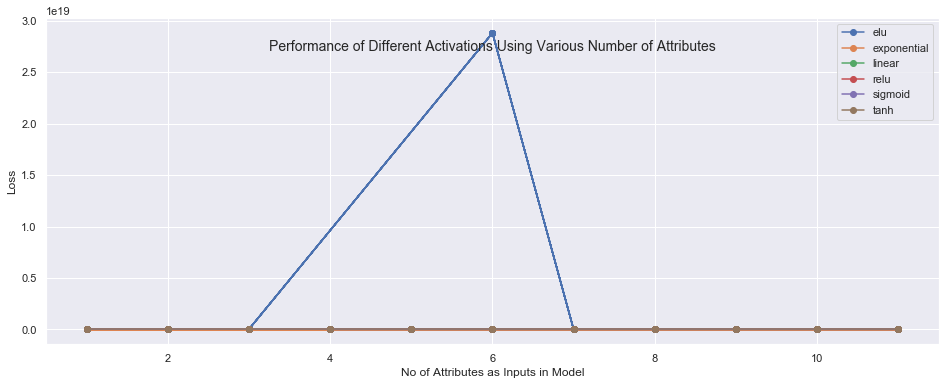

In [84]:
# Plot the actvations to see which performed best
plt.rcParams["figure.figsize"] = [16, 6]
groups = df.groupby(["activation"])

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for activation, group in groups:
    ax.plot(group["no_attrib"], group["loss"], marker='.', linestyle='-', ms=12, label=activation)
ax.legend()
ax.set_ylabel("Loss")
ax.set_xlabel("No of Attributes as Inputs in Model")
ax.text(.5,.9,"Performance of Different Activations Using Various Number of Attributes", horizontalalignment='center',transform=ax.transAxes,fontsize=14)

Text(0.5, 0.9, 'Performance of Different Optimiser Using Various Number of Attributes')

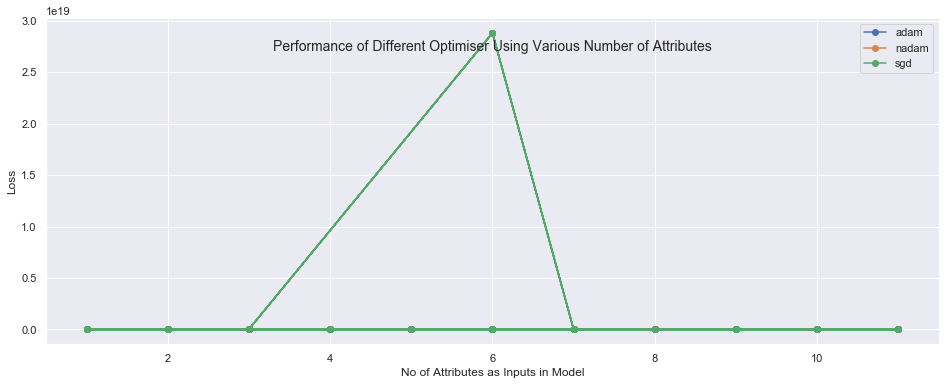

In [85]:
# Plot the actvations to see which performed best
plt.rcParams["figure.figsize"] = [16, 6]
groups = df.groupby('optimiser')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for optimiser, group in groups:
    ax.plot(group["no_attrib"], group["loss"], marker='.', linestyle='-', ms=12, label=optimiser)
ax.legend()
ax.set_ylabel("Loss")
ax.set_xlabel("No of Attributes as Inputs in Model")
ax.text(.5,.9,"Performance of Different Optimiser Using Various Number of Attributes", horizontalalignment='center',transform=ax.transAxes,fontsize=14)

In [86]:
# Sort the various model iterations according to loss to determine the best model(s) to chose) 
df.sort_values(by='loss', ascending=True)

,no_attrib,scaling,test_size,activation,optimiser,no_epochs,batch_size,loss
962,6,False,0.3,exponential,adam,100,10,8.006882e+00
1292,6,False,0.3,exponential,adam,100,10,8.006882e+00
890,11,False,0.3,sigmoid,sgd,100,10,8.569882e+00
626,11,False,0.3,sigmoid,sgd,100,10,8.569882e+00
1220,11,False,0.3,sigmoid,sgd,100,10,8.569882e+00
1197,10,False,0.3,relu,sgd,100,10,8.887720e+00
603,10,False,0.3,relu,sgd,100,10,8.887720e+00
867,10,False,0.3,relu,sgd,100,10,8.887720e+00
623,8,False,0.3,sigmoid,sgd,100,10,9.457667e+00
887,8,False,0.3,sigmoid,sgd,100,10,9.457667e+00
